# Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cptac
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from upsetplot import UpSet
import itertools
from upsetplot import from_contents, plot

In [3]:
import pandas as pd
import numpy as np

## This part quantile normalization is from https://github.com/huosan0123/quantile_normalization_python/blob/master/quantile_norm.py
"""
The script is used to do quantile normalization.
The process is like R.preprocessCore.normalize.quantiles().  
Input data should be a np.ndarray or np.matrix type
return a same np.ndarray() type
"""


def get_row_means(sorted_arr, rows, cols):
    """
    Given a dim=2 array, calculate its row means.
    As for Na, a float will be calculated by linear interpolation
    :param sorted_arr: sorted array of original arr. Na placed last on each column
    :param rows: rows of data, not counting header
    :param cols: rows of data, not counting header 
    :return: A new calloced row_means with size(rows) vector
    """
    eps = np.finfo(float).eps
    non_nas = rows - np.sum(np.isnan(sorted_arr), axis=0)
    row_means = np.zeros(rows, dtype=np.float64)

    for j in range(cols):
        non_na = non_nas[j]
        # if this column all is NA, skip. otherwise, row_means=nan, error
        if non_na == 0:
            continue
        
        if non_na == rows:
            for i in range(rows):
                row_means[i] += sorted_arr[i, j]

        else:
            for i in range(rows):
                sample_percent = float(i) / float(rows - 1)
                index_f = 1.0 + (non_na - 1.0) * sample_percent
                index_f_floor = np.floor(index_f + 4 * eps)
                index_f = index_f - index_f_floor

                if np.fabs(index_f <= 4 * eps):
                    index_f = 0.0

                if index_f == 0.0:
                    row_mean_id = int(np.floor(index_f_floor + 0.5))
                    row_means[i] += sorted_arr[row_mean_id - 1, j]
                elif index_f == 1.0:
                    row_mean_id = int(np.floor(index_f_floor + 1.5))
                    row_means[i] += sorted_arr[row_mean_id - 1, j]
                else:
                    row_mean_id = int(np.floor(index_f_floor + 0.5))

                    if row_mean_id < rows and row_mean_id > 0:
                        row_means[i] += (1.0 - index_f) * sorted_arr[row_mean_id-1, j] + \
                            index_f * sorted_arr[row_mean_id, j]
                    elif row_mean_id >= rows:
                        row_means[i] += sorted_arr[non_na - 1, j]
                    else:
                        row_means[i] += sorted_arr[0, j]
    row_means /= float(cols)
    return row_means


def get_ranks(sorted_arr, rows, cols):
    """
    sorted_arr is sorted in ascending order.
    rows, cols is its shape
    """
    ranks_arr = np.zeros((rows, cols), dtype=np.float64)
    ranks_arr[:, :] = np.NaN
    for c in range(cols):
        sorted_vec = sorted_arr[:, c]
        non_na = rows - np.sum(np.isnan(sorted_vec))

        i = 0
        while i < non_na:
            j = i
            # when meet ties, here after 5 lines do it.
            while j < non_na - 1 and sorted_vec[j] == sorted_vec[j+1]:
                j += 1
            if i != j:
                for k in range(i, j+1):
                    ranks_arr[k, c] = (i + j + 2.0) / 2.0
            else:
                ranks_arr[i, c] = i + 1
            i = j + 1

    return ranks_arr


def using_target(ranks_arr, index_arr, row_means, rows, cols):
    eps = np.finfo(float).eps
    non_nas = rows - np.sum(np.isnan(ranks_arr), axis=0)
    normed = np.zeros((rows, cols), dtype=np.float64)
    normed[:, :] = np.NaN

    for j in range(cols):
        non_na = non_nas[j]
        if non_na == rows:
            for i in range(rows):
                rank = ranks_arr[i, j]
                ori_i = index_arr[i, j]
                if rank - np.floor(rank) > 0.4:
                    normed[ori_i, j] = 0.5 * row_means[int(np.floor(rank)) - 1] + \
                        0.5 * row_means[int(np.floor(rank))]
                else:
                    normed[ori_i, j] = row_means[int(np.floor(rank)) - 1]
        else:
            for i in range(non_na):
                ori_i = index_arr[i, j]

                sample_percent = (ranks_arr[i, j] - 1.0) / float(non_na - 1)
                index_f = 1.0 + (rows - 1.0) * sample_percent
                index_f_floor = np.floor(index_f + 4 * eps)
                index_f -= index_f_floor

                if np.fabs(index_f) <= 4* eps:
                    index_f = 0.0

                if index_f == 0.0:
                    ind = int(np.floor(index_f_floor + 0.5))
                    normed[ori_i, j] = row_means[ind-1]
                elif index_f == 1.0:
                    ind = int(np.floor(index_f_floor + 1.5))
                    normed[ori_i, j] = row_means[ind-1]
                else:
                    ind = int(np.floor(index_f_floor + 0.5))
                    if (ind < rows) and ind > 0:
                        normed[ori_i, j] = (1.0 - index_f) * row_means[ind-1] + index_f * row_means[ind]
                    elif ind > rows:
                        normed[ori_i, j] = row_means[rows-1]
                    else:
                        normed[ori_i, j] = row_means[0]

    return normed


def quantile_normalize(input_arr):
    origin_arr = np.array(input_arr, dtype=np.float64)
    assert len(origin_arr.shape) == 2
    rows, cols = origin_arr.shape

    sorted_arr = np.sort(origin_arr, axis=0)
    ranks_arr = get_ranks(sorted_arr, rows, cols)
    row_means = get_row_means(sorted_arr, rows, cols)
    
    # index_arr is used to record the original position of origin arr.
    index_arr = np.argsort(origin_arr, axis=0)
    normed = using_target(ranks_arr, index_arr, row_means, rows, cols)

    return normed


In [4]:
# def quantile_normalize(df):
#     """
#     input: dataframe with numerical columns
#     output: dataframe with quantile normalized values
#     """
#     df_sorted = pd.DataFrame(
#         np.sort(df.values, axis=0), index=df.index, columns=df.columns
#     )
#     df_mean = df_sorted.mean(axis=1)
#     df_mean.index = np.arange(1, len(df_mean) + 1)
#     df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()
#     return df_qn

def do_qtn(df1):
    new_df = df1.T
    df_res = pd.DataFrame(quantile_normalize(new_df)).T
    df_res.columns = df1.columns
    df_res.index = df1.index
    return df_res

def get_all_mean_std(df1):
    # all_mean = np.nanmean(df1,axis=0)
    all_std = np.nanstd(df1, axis=0)
    # mean_m = np.nanmean(all_mean)
    mean_s = np.nanmean(all_std)
    return mean_s


def get_new_mu(m, s):
    new_m = m - 1.8 * s
    new_s = 0.3 * s
    return new_m, new_s


def impute_list(v1, m, s):
    n_na = np.sum(np.isnan(v1))
    np.random.seed(n_na)
    rd = np.random.normal(m, s, n_na).tolist()
    for i in range(len(v1)):
        if np.isnan(v1[i]):
            v1[i] = np.max([rd.pop(), 0])
    return v1


def do_z_score(df1):
    exp = np.array(df1)
    scaler = StandardScaler().fit(exp)
    exp_z = scaler.transform(exp)
    new_df = pd.DataFrame(exp_z, columns=df1.columns)
    new_df.insert(0, "PID", df1.index)
    return new_df


def impute_df(df1, mean_s):
    pro_list = df1.columns
    new_qt = []
    for i in range(len(pro_list)):
        # print(i)
        one_pro = pro_list[i]
        tmp_pro_exp = df1[one_pro].tolist()
        n_na = np.sum(np.isnan(tmp_pro_exp))
        if n_na == 0:
            new_qt.append(tmp_pro_exp)
            continue
        if n_na == len(tmp_pro_exp) - 1:
            new_m = np.nanmean(tmp_pro_exp)
            new_s = mean_s
        else:
            tmp_m = np.nanmean(tmp_pro_exp)
            tmp_s = np.nanstd(tmp_pro_exp)
            new_m, new_s = get_new_mu(tmp_m, tmp_s)
            new_s = np.min([new_s, mean_s])
        tmp_pro_exp = impute_list(tmp_pro_exp, new_m, new_s)
        if np.sum(np.isnan(tmp_pro_exp)) > 0:
            print("error in "+one_pro) 
        new_qt.append(tmp_pro_exp)
    imp_df = pd.DataFrame(np.array(new_qt).T, columns=pro_list)
    imp_df.index = df1.index
    return imp_df
def var_filter(df1):
    var_list = df1.var()
    zero_variance_cols = var_list[var_list == 0].index
    df1 = df1.drop(zero_variance_cols, axis=1)
    return df1

def get_all_process_df(df_res):
    # # var filter
    # df_res = var_filter(df_res)
    # qtn
    df_res = do_qtn(df_res)
    # impute
    mean_s = get_all_mean_std(df_res)
    df_res = impute_df(df_res, mean_s)
    # zscore
    df_res = do_z_score(df_res)
    return df_res

def split_TN_df(df_res):
    tmp_df = df_res.copy()
    tmp_df['Normal'] = [0 if ('NX' in x ) or ('.' in x) else 1 for x in tmp_df.index]
    df_T = tmp_df[tmp_df['Normal'] == 1]
    df_N = tmp_df[tmp_df['Normal'] == 0]
    df_T = df_T.drop(['Normal'], axis=1)
    df_N = df_N.drop(['Normal'], axis=1)
    return df_T, df_N

def get_all_process_df_split(df_res):
    df_T, df_N = split_TN_df(df_res)
    df_T = do_qtn(df_T)
    if df_N.shape[0] > 0:
        df_N = do_qtn(df_N)
        df_T = pd.concat([df_T, df_N], axis=0)
    mean_s = get_all_mean_std(df_T)
    df_T = impute_df(df_T, mean_s)
    df_T, df_N = split_TN_df(df_T)
    df_T = do_z_score(df_T)
    if df_N.shape[0] > 0:
        df_N = do_z_score(df_N)
        df_T = pd.concat([df_T, df_N], axis=0)
    return df_T


## For protein data

In [5]:
cptac.get_cancer_info()

{'brca': 'Breast invasive carcinoma',
 'ccrcc': 'Clear cell renal cell carcinoma',
 'coad': 'Colon adenocarcinoma',
 'gbm': 'Glioblastoma multiforme',
 'hnscc': 'Head and Neck squamous cell carcinoma',
 'lscc': 'Lung squamous cell carcinoma',
 'luad': 'Lung adenocarcinoma',
 'ov': 'Ovarian serous cystadenocarcinoma',
 'pda': 'Pancreatic ductal adenocarcinoma',
 'pdac': 'Pancreatic ductal adenocarcinoma',
 'ucec': 'Uterine Corpus Endometrial Carcinoma'}

In [6]:
cptac.get_source_options()['Cancer'][4]

['coad', 'luad', 'ccrcc', 'gbm', 'ov', 'hnscc', 'brca', 'lscc', 'pdac', 'ucec']

In [7]:
cancer_type = ['Brca', 'Lscc', 'Hnscc', 'Ov', 'Coad', 'Ccrcc', 'Pdac', 'Gbm', 'Luad', 'Ucec']

In [8]:
brca = cptac.Brca()
lscc = cptac.Lscc()
hnscc = cptac.Hnscc()
ov = cptac.Ov()
coad = cptac.Coad()
ccrcc = cptac.Ccrcc()
pdac = cptac.Pdac()
gbm = cptac.Gbm()
luad = cptac.Luad()
ucec = cptac.Ucec()
cancer_data_list = [brca, lscc, hnscc, ov, coad, ccrcc, pdac, gbm, luad, ucec]

In [9]:
ucec.get_transcriptomics('bcm')

Name,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,hsa-mir-1253,hsa-mir-423
Database_ID,ENSG00000121410.12,ENSG00000268895.6,ENSG00000148584.15,ENSG00000175899.15,ENSG00000245105.4,ENSG00000166535.20,ENSG00000256661.1,ENSG00000256904.1,ENSG00000256069.7,ENSG00000184389.9,...,ENSG00000198455.4,ENSG00000070476.15,ENSG00000203995.10,ENSG00000232242.2,ENSG00000162378.13,ENSG00000159840.16,ENSG00000274572.1,ENSG00000074755.15,ENSG00000272920.1,ENSG00000266919.3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,2.54,5.11,3.60,13.75,6.45,7.08,1.80,0.00,2.60,1.16,...,10.17,10.61,5.54,0.0,11.85,10.60,0.0,11.87,0.0,0.0
C3L-00008,4.40,4.63,5.49,13.89,6.61,6.97,0.00,2.74,3.25,0.00,...,9.79,10.48,7.79,0.0,12.28,11.28,0.0,11.93,0.0,0.0
C3L-00032,4.83,7.26,3.73,14.48,6.91,9.56,0.98,0.00,3.26,0.00,...,9.43,9.97,6.48,0.0,11.72,10.37,0.0,11.70,0.0,0.0
C3L-00084,4.73,6.01,5.37,15.17,7.93,3.86,0.00,0.00,3.73,1.15,...,9.23,10.37,7.47,0.0,11.86,10.13,0.0,11.19,0.0,0.0
C3L-00090,4.14,6.24,5.69,13.87,6.79,4.32,0.00,0.00,3.23,0.00,...,9.69,9.64,7.60,0.0,11.98,10.31,0.0,11.45,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-00383.N,6.11,7.55,2.23,15.93,9.14,5.75,0.00,0.00,5.14,1.79,...,10.06,10.48,6.53,0.0,12.50,11.54,0.0,11.94,0.0,0.0
C3N-00858.N,6.13,8.34,2.97,15.13,8.94,5.60,0.00,0.00,4.09,2.14,...,10.03,10.61,6.35,0.0,12.67,10.99,0.0,12.02,0.0,0.0


In [10]:
ucec.get_proteomics('umich')

Name,ARF5,M6PR,ESRRA,FKBP4,NDUFAF7,FUCA2,DBNDD1,SEMA3F,CFTR,CYP51A1,...,SCRIB,WIZ,BPIFB4,LDB1,WIZ,TSGA10,RFX7,SWSAP1,MSANTD2,SVIL
Database_ID,ENSP00000000233.5,ENSP00000000412.3,ENSP00000000442.6,ENSP00000001008.4,ENSP00000002125.4,ENSP00000002165.5,ENSP00000002501.6,ENSP00000002829.3,ENSP00000003084.6,ENSP00000003100.8,...,ENSP00000501177.1,ENSP00000501256.3,ENSP00000501266.1,ENSP00000501277.1,ENSP00000501300.1,ENSP00000501312.1,ENSP00000501317.1,ENSP00000501355.1,ENSP00000501466.1,ENSP00000501521.1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,-0.056513,0.016557,0.002569,0.389819,0.603610,-0.332543,-0.790426,NaN,0.822732,0.039134,...,0.161720,-0.884807,NaN,0.268247,0.125392,-0.880833,0.108554,0.107413,-0.085833,NaN
C3L-00008,0.549959,-0.206129,0.905784,-0.303631,0.018767,0.503513,0.950955,0.080142,NaN,-0.063213,...,NaN,0.054284,NaN,-0.106450,0.380557,-0.756099,0.264611,0.044423,-0.248319,-1.206596
C3L-00032,0.088681,-0.154447,-0.190515,0.170753,0.196356,0.544194,-0.179078,NaN,NaN,0.377405,...,-1.086905,0.055991,NaN,-0.021986,-0.229645,1.923986,NaN,-0.176694,-0.332384,-1.330653
C3L-00084,-0.846555,0.027740,NaN,0.178700,0.264054,-0.183548,0.077215,-0.247164,0.152277,-0.279549,...,-0.125796,0.944212,NaN,0.917409,0.026862,-0.885976,-0.006510,-0.014162,0.365158,NaN
C3L-00090,0.539019,0.956619,-0.039516,0.323656,0.064605,0.173433,-0.524325,-0.038590,-0.311486,0.309905,...,0.853362,-0.716947,NaN,-0.286277,-0.046076,0.089645,-0.444506,-0.072531,-0.463495,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NX5.N,0.149415,0.033680,0.608685,-0.424392,-0.006035,0.630414,0.073165,-0.130496,0.476583,-0.431928,...,-1.005260,-0.477073,NaN,0.365370,0.106410,0.165221,-0.204772,NaN,0.406125,-0.162471
NX6.N,0.105362,0.129697,0.242724,0.071088,-0.194179,-0.291171,0.118912,-0.060324,-0.073102,-0.084028,...,-0.594133,-0.807845,NaN,0.250239,0.173849,-0.370080,-0.214186,NaN,0.242997,0.035650


In [11]:
pro_df_list = []
for i in range(len(cancer_data_list)-1):
    one_c = cancer_data_list[i]
    one_pro = one_c.get_proteomics('bcm').copy()
    one_pro.columns = one_pro.columns.droplevel(1)
    pro_df_list.append(one_pro)
    print(cancer_type[i], one_pro.shape)

Brca (122, 12021)
Lscc (207, 12757)
Hnscc (170, 11560)
Ov (102, 10589)
Coad (197, 9152)
Ccrcc (183, 11259)
Pdac (149, 11404)
Gbm (99, 12098)
Luad (207, 12431)


In [12]:
## For UCEC tmp
ucec_tumor = pd.read_csv('/Raw_data/CPTAC_Pancancer/Proteome_BCM_GENCODE_v34_harmonized_v1/UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt', sep='\t')
ucec_normal = pd.read_csv('/Raw_data/CPTAC_Pancancer/Proteome_BCM_GENCODE_v34_harmonized_v1/UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt', sep='\t')
ucec_tumor

,idx,C3N-00858,C3L-01252,C3L-00947,C3N-00734,C3L-01248,C3N-00850,C3L-00361,C3L-01249,C3N-00383,...,C3L-00921,C3L-00156,C3L-00137,C3N-00848,C3L-00781,C3N-01802,C3N-00151,C3L-00136,C3L-00008,C3N-00847
0,ENSG00000000003.15,25.369376,24.874685,24.642860,25.793570,25.189386,25.291879,25.109497,26.165428,26.368581,...,25.861111,26.700272,25.273497,25.541244,24.630004,23.822078,24.819495,24.071893,27.112009,25.404112
1,ENSG00000000419.12,25.593640,25.373269,25.722831,25.624123,25.330753,25.383039,25.775150,24.940247,25.704433,...,25.624567,25.639531,25.710356,25.079821,25.783280,25.454908,25.524339,25.997218,25.981483,25.068522
2,ENSG00000000457.14,23.154638,22.695062,22.887851,22.731202,22.694571,23.519138,23.443617,21.991244,22.958170,...,22.701181,23.169421,22.944180,23.063786,22.642653,22.937866,22.304799,23.486702,22.947636,22.919499
3,ENSG00000000460.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.784513,15.946479,16.727141,16.724827,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000000938.13,20.748682,20.992448,20.873161,21.816702,21.644318,20.802541,20.170390,22.186396,20.745190,...,20.905951,20.998808,20.195099,21.271246,21.292763,21.508793,21.323157,20.813152,20.632154,20.265671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11889,ENSG00000284862.3,19.906673,20.096594,19.610953,20.445536,20.084560,20.861153,NaN,NaN,NaN,...,19.329016,19.842409,19.562317,20.852537,19.854977,19.210530,22.171624,19.559305,20.205977,19.529487
11890,ENSG00000285025.1,23.021230,21.287474,21.833076,21.589395,21.507652,22.298235,22.923445,22.422048,22.469102,...,22.681656,22.058231,22.117165,21.880364,22.348413,21.311594,22.285541,21.839332,22.812517,23.167338
11891,ENSG00000285723.1,22.494645,22.134041,21.802560,21.764001,21.998489,22.004590,22.394915,22.898861,23.279357,...,22.643250,22.297360,21.677549,21.414754,22.040892,22.340708,23.074909,22.157164,22.179689,21.404393
11892,ENSG00000286053.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.379323,20.574372,20.641398,20.958449,20.247147,20.256249,20.477779,20.541767,20.595134,20.901046


In [13]:
ucec_name = pd.read_csv('/Raw_data/CPTAC_Pancancer/Proteome_UMich_SinaiPreprocessed_GENECODE34_v1/observed_data/UCEC_PanCan_Proteome_V1.1_UMich_GENCODE34_Sinai_observed.tsv', sep='\t')
ucec_name['idx']=ucec_name.index
ucec_name

,NumberPSM,ProteinID,MaxPepProb,ReferenceIntensity,GENECODE34_Symbol,HGNC_Approved_Symbol,CPT0078320004,CPT0078360001,CPT0080620001,CPT0080610003,...,CPT0070260003,NX8,NX9,CPT0080030003,CPT0066620003,CPT0000730011,CPT0001300009,CPT0027650003,Withdrawn (CPT0097730003),idx
ENSG00000000003.15,112,ENSP00000362111.4,1.0000,25.354516,TSPAN6,TSPAN6,25.797990,24.798108,24.946850,25.294942,...,25.046127,25.212174,24.368606,24.224551,25.238819,24.478586,27.570065,25.833314,24.568086,ENSG00000000003.15
ENSG00000000419.12,202,ENSP00000360638.4,1.0000,25.895840,DPM1,DPM1,26.026044,25.380699,25.643460,25.801949,...,26.218888,26.004142,25.861621,25.884968,25.955571,26.436440,26.420439,25.492053,24.989656,ENSG00000000419.12
ENSG00000000457.14,143,ENSP00000356745.5,1.0000,23.031642,SCYL3,SCYL3,23.545835,23.001432,23.075998,23.078494,...,23.025199,23.002643,23.071157,23.325400,22.681638,23.883508,23.335335,23.306723,22.704718,ENSG00000000457.14
ENSG00000000460.17,3,ENSP00000286031.6,1.0000,16.328671,C1orf112,C1orf112,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000000460.17
ENSG00000000938.13,55,ENSP00000363116.1,1.0000,21.083879,FGR,FGR,21.099230,21.106716,21.063952,21.347114,...,21.652504,21.029068,21.326129,21.872183,21.683411,21.164789,20.980733,20.608058,20.961228,ENSG00000000938.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284862.3,21,ENSP00000417960.2,1.0000,20.475299,CCDC39,CCDC39,20.242995,20.351824,20.208317,20.436125,...,20.190426,20.105345,19.462855,19.535091,22.546212,19.889758,20.547356,19.859436,21.277393,ENSG00000284862.3
ENSG00000285025.1,22,ENSP00000490747.1,0.9993,22.287167,AL022312.1,AL022312.1,23.410173,21.659242,22.309441,21.647125,...,22.725988,21.643918,21.755563,21.671652,22.662054,22.208306,23.197934,23.558749,21.178841,ENSG00000285025.1
ENSG00000285723.1,33,ENSP00000497510.1,1.0000,22.307963,AL034430.2,AL034430.2,22.874691,22.884927,22.928842,22.507995,...,22.413272,22.080946,22.183116,22.718153,23.464759,22.531508,22.554414,21.766019,21.061536,ENSG00000285723.1
ENSG00000286053.1,13,ENSP00000475224.1,1.0000,20.973974,ASDURF,ASDURF,NaN,NaN,NaN,NaN,...,20.589222,20.976520,20.734364,20.598478,20.823750,20.888820,20.943088,21.254168,20.679106,ENSG00000286053.1


In [14]:
ucec_name_df = ucec_name[['idx','HGNC_Approved_Symbol']]
ucec_name_df

,idx,HGNC_Approved_Symbol
ENSG00000000003.15,ENSG00000000003.15,TSPAN6
ENSG00000000419.12,ENSG00000000419.12,DPM1
ENSG00000000457.14,ENSG00000000457.14,SCYL3
ENSG00000000460.17,ENSG00000000460.17,C1orf112
ENSG00000000938.13,ENSG00000000938.13,FGR
...,...,...
ENSG00000284862.3,ENSG00000284862.3,CCDC39
ENSG00000285025.1,ENSG00000285025.1,AL022312.1
ENSG00000285723.1,ENSG00000285723.1,AL034430.2
ENSG00000286053.1,ENSG00000286053.1,ASDURF


In [15]:
ucec_tumor = ucec_tumor.merge(ucec_name_df, on='idx', how='left')
ucec_tumor.index = ucec_tumor['HGNC_Approved_Symbol']
ucec_tumor.drop_duplicates(subset=['HGNC_Approved_Symbol'], keep='first', inplace=True)
ucec_tumor = ucec_tumor.drop(['idx','HGNC_Approved_Symbol'], axis=1)
ucec_tumor

,C3N-00858,C3L-01252,C3L-00947,C3N-00734,C3L-01248,C3N-00850,C3L-00361,C3L-01249,C3N-00383,C3L-00949,...,C3L-00921,C3L-00156,C3L-00137,C3N-00848,C3L-00781,C3N-01802,C3N-00151,C3L-00136,C3L-00008,C3N-00847
HGNC_Approved_Symbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,25.369376,24.874685,24.642860,25.793570,25.189386,25.291879,25.109497,26.165428,26.368581,25.028023,...,25.861111,26.700272,25.273497,25.541244,24.630004,23.822078,24.819495,24.071893,27.112009,25.404112
DPM1,25.593640,25.373269,25.722831,25.624123,25.330753,25.383039,25.775150,24.940247,25.704433,25.670138,...,25.624567,25.639531,25.710356,25.079821,25.783280,25.454908,25.524339,25.997218,25.981483,25.068522
SCYL3,23.154638,22.695062,22.887851,22.731202,22.694571,23.519138,23.443617,21.991244,22.958170,22.805338,...,22.701181,23.169421,22.944180,23.063786,22.642653,22.937866,22.304799,23.486702,22.947636,22.919499
C1orf112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.784513,15.946479,16.727141,16.724827,NaN,NaN,NaN,NaN,NaN,NaN
FGR,20.748682,20.992448,20.873161,21.816702,21.644318,20.802541,20.170390,22.186396,20.745190,20.627408,...,20.905951,20.998808,20.195099,21.271246,21.292763,21.508793,21.323157,20.813152,20.632154,20.265671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCDC39,19.906673,20.096594,19.610953,20.445536,20.084560,20.861153,NaN,NaN,NaN,NaN,...,19.329016,19.842409,19.562317,20.852537,19.854977,19.210530,22.171624,19.559305,20.205977,19.529487
AL022312.1,23.021230,21.287474,21.833076,21.589395,21.507652,22.298235,22.923445,22.422048,22.469102,21.855962,...,22.681656,22.058231,22.117165,21.880364,22.348413,21.311594,22.285541,21.839332,22.812517,23.167338
AL034430.2,22.494645,22.134041,21.802560,21.764001,21.998489,22.004590,22.394915,22.898861,23.279357,22.087888,...,22.643250,22.297360,21.677549,21.414754,22.040892,22.340708,23.074909,22.157164,22.179689,21.404393


In [16]:
ucec_normal = ucec_normal.merge(ucec_name_df, on='idx', how='left')
ucec_normal.index = ucec_normal['HGNC_Approved_Symbol']
ucec_normal.drop_duplicates(subset=['HGNC_Approved_Symbol'], keep='first', inplace=True)
ucec_normal = ucec_normal.drop(['idx','HGNC_Approved_Symbol'], axis=1)
ucec_normal

,NX1,NX2,NX3,NX4,NX5,NX6,NX7,NX8,NX9,NX12,NX17,NX13,NX14,NX10,NX16,NX18,NX11,NX15
HGNC_Approved_Symbol,,,,,,,,,,,,,,,,,,
TSPAN6,25.056031,24.260521,24.303117,24.785347,24.917806,24.249563,24.319135,24.793292,23.963740,24.117581,23.343176,24.723122,24.184025,24.057446,24.155399,24.729833,24.675616,24.454607
DPM1,25.574974,25.489734,25.715940,25.642173,25.680536,25.672027,25.584854,25.572102,25.431949,25.964160,25.501115,25.768110,25.927471,25.765222,25.657326,25.861043,25.784558,25.958162
SCYL3,23.067145,22.825778,22.381371,22.602709,22.476198,22.617290,22.266673,22.620471,22.687847,22.778049,23.234238,22.399950,23.071033,22.681829,22.778145,22.839193,22.492995,22.706641
C1orf112,15.675844,15.042369,NaN,NaN,14.918475,15.448217,14.611809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FGR,20.470261,21.883914,20.294663,20.617781,20.887053,21.027755,20.673522,20.679685,20.971811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCDC39,18.601354,19.237825,NaN,NaN,18.775502,18.816617,19.225250,19.771309,19.139494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AL022312.1,21.913592,21.829235,21.974074,21.938045,22.105998,22.119001,22.264919,21.284321,21.394111,21.682986,21.448186,21.887363,21.935927,21.480096,21.331859,21.628200,22.089139,22.050533
AL034430.2,21.668823,21.459480,21.971985,22.044926,21.945409,21.882350,21.724954,21.714088,21.814560,22.012740,22.625306,21.833888,21.917728,21.957831,21.908868,21.640573,21.658343,21.743866


In [17]:
ucec_merged = ucec_tumor.merge(ucec_normal, on='HGNC_Approved_Symbol', how='outer')
ucec_merged

,C3N-00858,C3L-01252,C3L-00947,C3N-00734,C3L-01248,C3N-00850,C3L-00361,C3L-01249,C3N-00383,C3L-00949,...,NX9,NX12,NX17,NX13,NX14,NX10,NX16,NX18,NX11,NX15
HGNC_Approved_Symbol,,,,,,,,,,,,,,,,,,,,,
TSPAN6,25.369376,24.874685,24.642860,25.793570,25.189386,25.291879,25.109497,26.165428,26.368581,25.028023,...,23.963740,24.117581,23.343176,24.723122,24.184025,24.057446,24.155399,24.729833,24.675616,24.454607
DPM1,25.593640,25.373269,25.722831,25.624123,25.330753,25.383039,25.775150,24.940247,25.704433,25.670138,...,25.431949,25.964160,25.501115,25.768110,25.927471,25.765222,25.657326,25.861043,25.784558,25.958162
SCYL3,23.154638,22.695062,22.887851,22.731202,22.694571,23.519138,23.443617,21.991244,22.958170,22.805338,...,22.687847,22.778049,23.234238,22.399950,23.071033,22.681829,22.778145,22.839193,22.492995,22.706641
C1orf112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FGR,20.748682,20.992448,20.873161,21.816702,21.644318,20.802541,20.170390,22.186396,20.745190,20.627408,...,20.971811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.717135,15.370659,15.357822,15.504302,15.808118,15.694948,15.324406,15.519633,15.284455
C4orf46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.044320,14.917724,15.773395,14.167234,14.791872,14.601310,14.866606,15.046169,14.825286
DPF3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,14.810077,16.084177,14.965795,14.705804,15.177350,16.308382,15.219036,15.067034,15.704713


In [18]:
ucec_merged = ucec_merged.T
ucec_merged

HGNC_Approved_Symbol,TSPAN6,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,...,BTBD6,GALNT17,GZMM,C2CD4A,RPL39,ZNF805,C4orf46,DPF3,IGKV2D-30,GATC
C3N-00858,25.369376,25.593640,23.154638,NaN,20.748682,27.179819,25.594512,25.463134,23.006256,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01252,24.874685,25.373269,22.695062,NaN,20.992448,28.674770,25.071935,26.435040,22.850594,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00947,24.642860,25.722831,22.887851,NaN,20.873161,27.731000,25.180465,25.680156,22.909684,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3N-00734,25.793570,25.624123,22.731202,NaN,21.816702,27.773122,25.345331,25.344346,22.492705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01248,25.189386,25.330753,22.694571,NaN,21.644318,28.160909,25.016271,25.424700,22.220885,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NX10,24.057446,25.765222,22.681829,NaN,NaN,28.309382,24.727083,25.696390,22.868352,NaN,...,15.667424,14.664958,16.186318,16.605814,20.078309,15.808118,14.791872,15.177350,15.823132,15.336943
NX16,24.155399,25.657326,22.778145,NaN,NaN,28.345345,24.801265,25.927584,23.094360,NaN,...,15.424374,14.446235,16.624861,16.038934,19.546693,15.694948,14.601310,16.308382,17.761337,14.468329
NX18,24.729833,25.861043,22.839193,NaN,NaN,28.233492,25.137851,26.278420,22.825637,NaN,...,15.278648,14.288921,15.461317,14.382041,19.728489,15.324406,14.866606,15.219036,15.524053,14.493165
NX11,24.675616,25.784558,22.492995,NaN,NaN,28.579532,25.228549,26.647906,23.126995,NaN,...,15.463968,14.516119,16.176362,14.517661,20.166276,15.519633,15.046169,15.067034,16.424915,15.689787


In [19]:
pro_df_list.append(ucec_merged)

# Merge all cancer data

In [20]:
pro_dict = {}
for i in range(len(pro_df_list)):
    tmp_df = pro_df_list[i]
    sam_n = tmp_df.shape[0]
    pro_l = set(tmp_df.columns.tolist())
    ch_name = cancer_type[i]+'_'+str(sam_n)
    pro_dict[ch_name] = pro_l


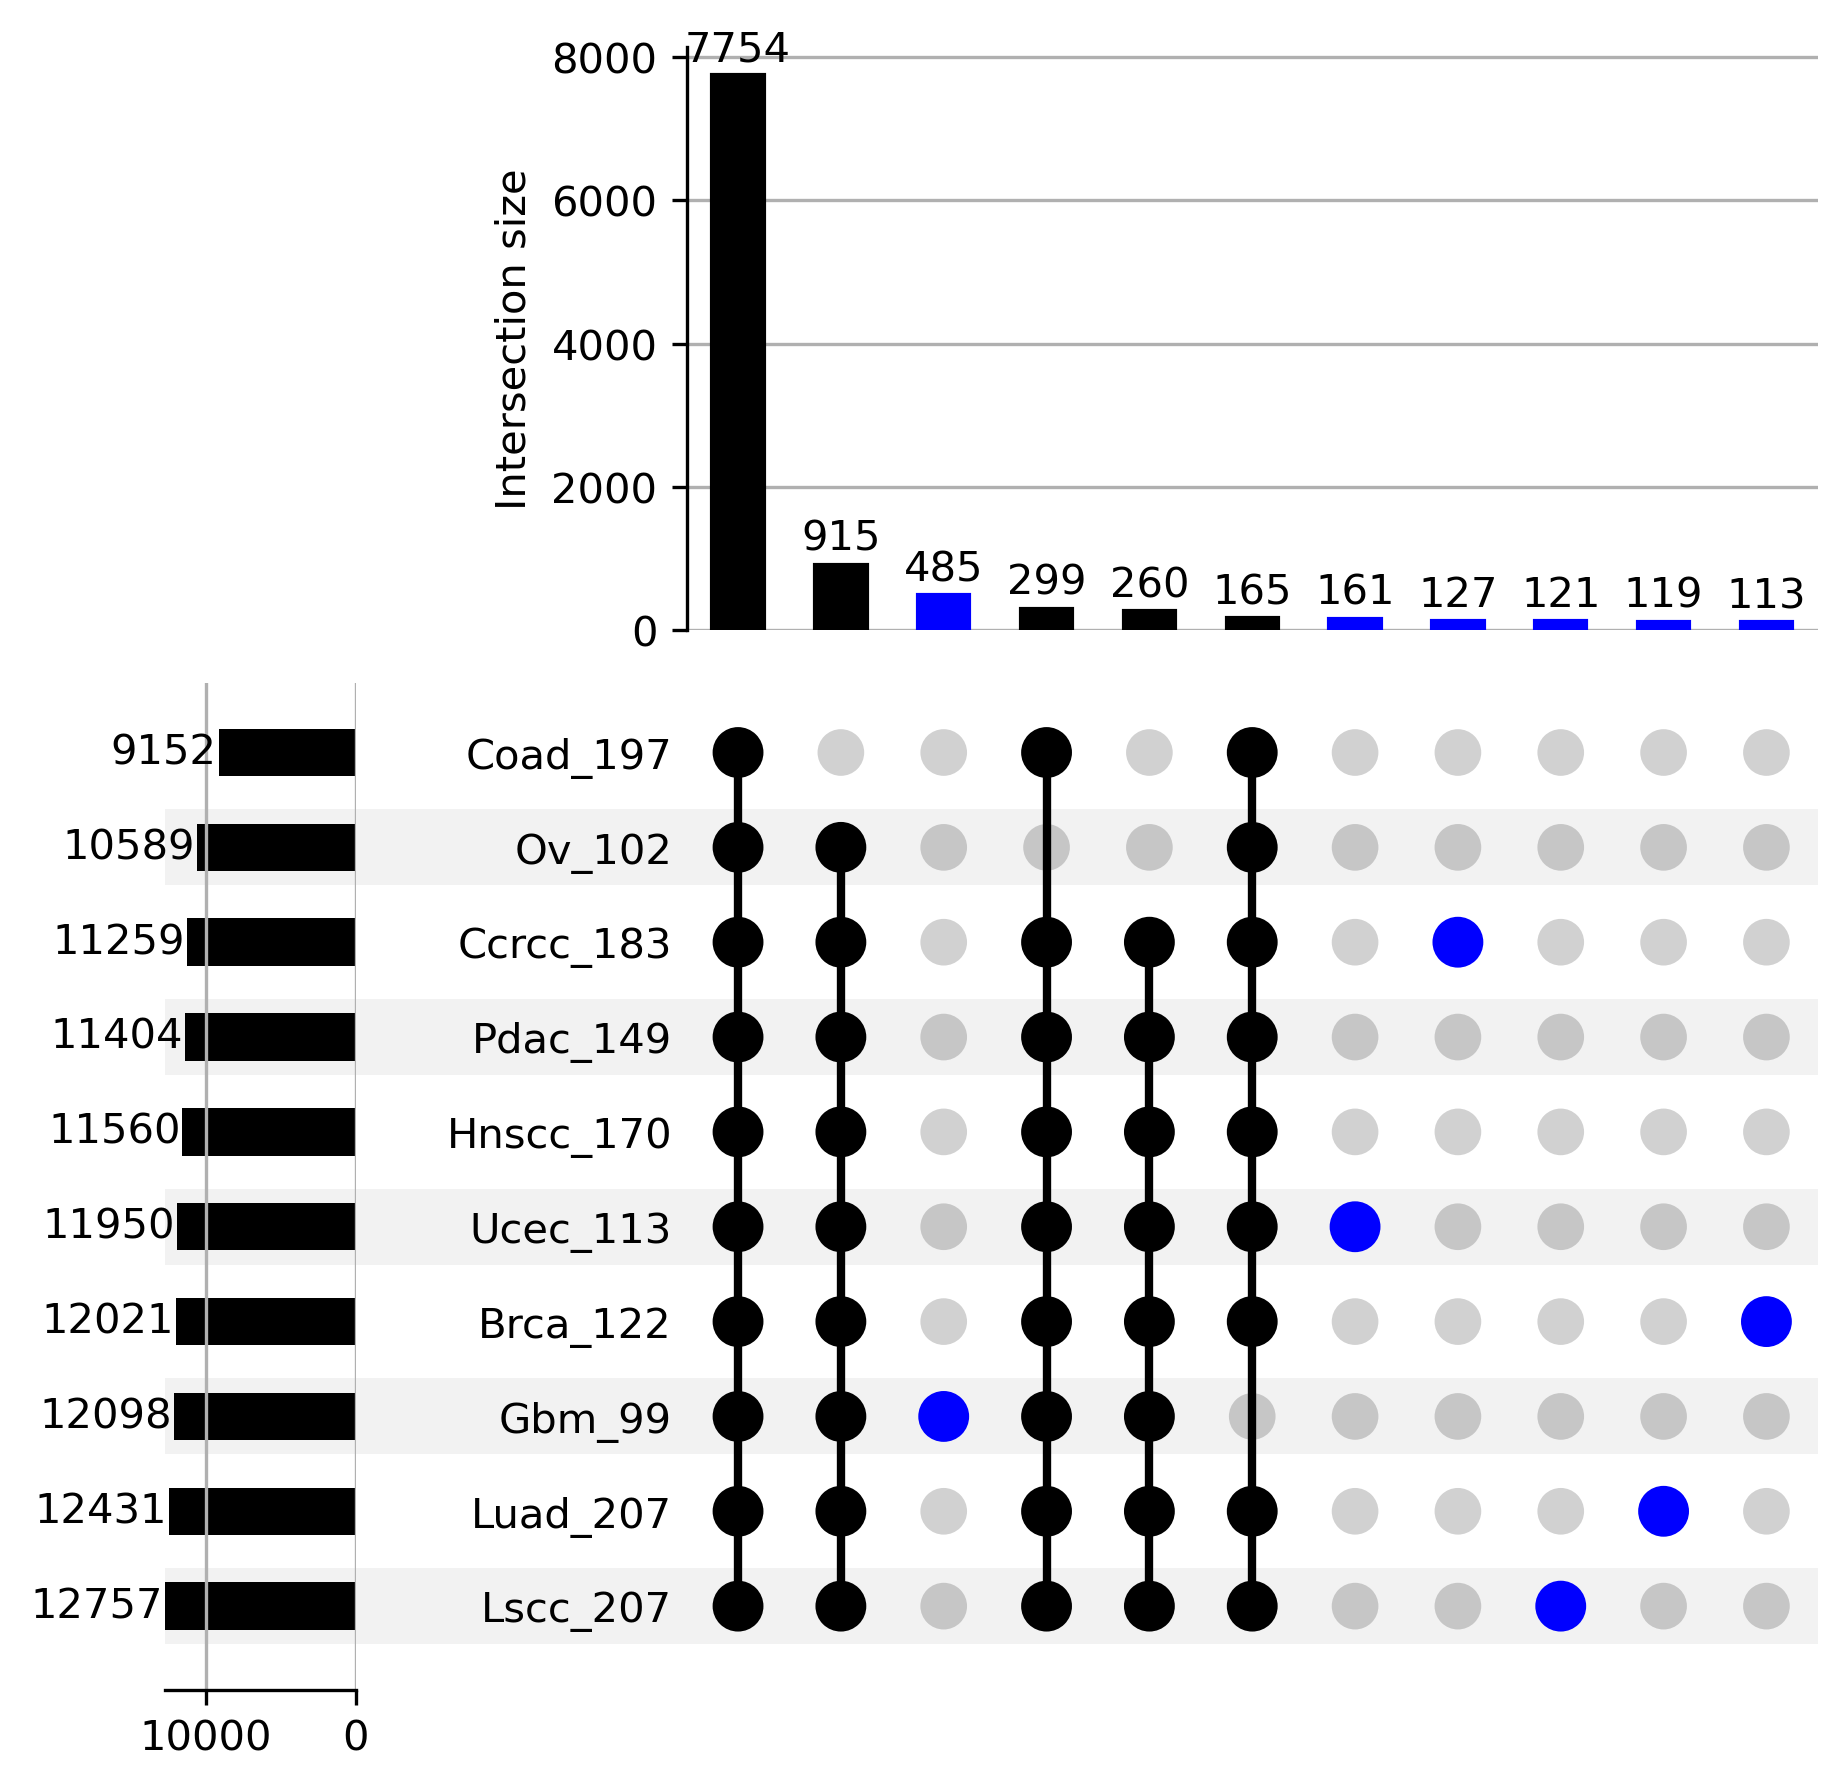

In [101]:
fig = plt.figure(figsize=(10, 15),dpi=300)
df = from_contents(pro_dict)
upset = UpSet(df,sort_by='cardinality',show_counts='%d',min_subset_size=100)
upset.style_subsets(max_degree=1,
                    facecolor="blue")
upset.plot(fig=fig)
plt.show()

# Normalization and merge data

In [21]:
pro_df_list_z = []
for i in range(len(pro_df_list)):
    tmp_df = pro_df_list[i]
    new_df_z = get_all_process_df(tmp_df)
    pro_df_list_z.append(new_df_z)
    print(cancer_type[i], new_df_z.shape)

Brca (122, 12022)
Lscc (207, 12758)
Hnscc (170, 11561)
Ov (102, 10590)
Coad (197, 9153)
Ccrcc (183, 11260)
Pdac (149, 11405)
Gbm (99, 12099)
Luad (207, 12432)
Ucec (113, 11951)


In [105]:
shared_pro_list = []
for i in range(len(pro_df_list_z)):
    tmp_df = pro_df_list_z[i]
    sam_n = tmp_df.shape[0]
    pro_l = set(tmp_df.columns[1:].tolist())
    if i == 0:
        shared_pro_list = pro_l
    shared_pro_list = shared_pro_list.intersection(pro_l)
shared_pro_list = list(shared_pro_list)
print(len(shared_pro_list))

7754


In [106]:
merged_pro_df = pd.DataFrame()
for i in range(len(pro_df_list_z)):
    tmp_df = pro_df_list_z[i]
    sam_n = tmp_df.shape[0]
    ch_name = cancer_type[i]
    tmp_df['Cohort'] = ch_name
    new_df = tmp_df[['PID','Cohort']+shared_pro_list]
    merged_pro_df = pd.concat([merged_pro_df,new_df],axis=0)
merged_pro_df.shape

(1549, 7756)

In [110]:
merged_pro_df.to_csv('./../CPTAC_pancancer/Pretrain/merged_pro_cohort_df.csv',index=False)

In [108]:
merged_pro_mat = merged_pro_df.drop(['Cohort'],axis=1)
merged_pro_mat

,PID,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,01BR001,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,...,0.917994,-1.365615,-0.218110,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754
1,01BR008,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,...,-0.364908,-0.637128,-0.206555,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492
2,01BR009,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,...,0.900607,0.617207,0.622614,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971
3,01BR010,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,...,-0.246015,0.893164,0.823663,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842
4,01BR015,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,...,0.417653,0.392018,0.906453,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,NX10,-0.970949,0.927515,-0.441864,-0.687578,1.133735,-0.890225,0.452179,0.786106,-0.238070,...,0.627781,-0.113712,0.775392,-0.716412,1.610838,-1.129755,-1.018968,-0.278560,-0.260703,1.080986
109,NX16,-0.343485,0.217685,-0.889214,0.488336,0.402929,-0.279217,0.866932,-0.617793,-0.251701,...,1.189584,-0.406077,-0.424346,-0.883768,1.520969,-1.085067,-0.244732,-0.680381,-0.481476,0.185272
110,NX18,-0.258244,0.195290,-0.173148,-0.174214,-0.181438,0.296693,0.113486,-0.266258,-0.318079,...,0.875791,0.347956,0.357953,-0.706914,0.928833,-1.027306,-0.297889,1.487797,0.060109,-0.018510
111,NX11,-0.950491,1.884100,0.224693,-0.043332,-0.429293,-0.020788,0.063377,-0.451420,-0.199369,...,1.368443,1.044459,0.104604,-0.421099,1.578959,-1.266199,-0.598630,0.856165,-0.239782,0.096446


In [109]:
merged_pro_mat.to_csv('./../CPTAC_pancancer/Pretrain/merged_pro_df.csv',index=False)

# Normalization in Tumor and Normal seperately and merge data

In [208]:
pro_df_list_z = []
for i in range(len(pro_df_list)):
    tmp_df = pro_df_list[i]
    new_df_z = get_all_process_df_split(tmp_df)
    pro_df_list_z.append(new_df_z)
    print(cancer_type[i], new_df_z.shape)

Brca (122, 12022)
Lscc (207, 12758)
Hnscc (170, 11561)
Ov (102, 10590)
Coad (197, 9153)
Ccrcc (183, 11260)
Pdac (149, 11405)
Gbm (99, 12099)
Luad (207, 12432)
Ucec (113, 11951)


In [209]:
pro_df_list_z[0].head()

Name,PID,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,...,ZSWIM8,ZSWIM9,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1
0,01BR001,1.173072,0.658011,-0.452420,0.593733,0.660198,-0.182332,1.369389,-1.531661,0.400701,...,1.121331,-0.677608,-0.709476,-0.307408,0.723458,0.187060,2.224554,1.121849,0.378777,-2.083832
1,01BR008,-0.661804,0.188702,1.251228,-0.264813,0.730875,-1.197318,-0.993923,-0.884185,-0.241204,...,0.829579,-0.725267,0.421458,0.448648,1.119457,0.879870,1.798490,0.119469,-0.303406,0.481823
2,01BR009,0.281326,1.749534,1.616247,-0.556543,-0.125319,-0.514715,-1.191741,-2.070662,-0.337744,...,-0.150283,-0.554094,-0.628808,0.158419,-0.158629,-0.146701,0.646599,0.804635,-0.283892,0.069616
3,01BR010,-1.002999,-1.165119,-0.769888,-0.163833,0.390044,2.382049,3.030279,-1.407032,-0.180982,...,-0.352807,0.696190,-0.165284,2.265391,-1.582426,-0.683765,-0.315004,-1.285938,1.213664,0.020122
4,01BR015,0.260635,-0.772257,-0.507880,-0.518674,1.452630,0.614126,0.782603,-0.619992,-0.192454,...,-0.021318,-0.569484,-0.135114,-0.355038,-0.272129,1.179714,-1.247524,0.686359,1.214570,-1.176972


In [210]:
shared_pro_list = []
for i in range(len(pro_df_list_z)):
    tmp_df = pro_df_list_z[i]
    sam_n = tmp_df.shape[0]
    pro_l = set(tmp_df.columns[1:].tolist())
    if i == 0:
        shared_pro_list = pro_l
    shared_pro_list = shared_pro_list.intersection(pro_l)
shared_pro_list = list(shared_pro_list)
print(len(shared_pro_list))

7754


In [211]:
merged_pro_df = pd.DataFrame()
for i in range(len(pro_df_list_z)):
    tmp_df = pro_df_list_z[i]
    sam_n = tmp_df.shape[0]
    ch_name = cancer_type[i]
    tmp_df['Cohort'] = ch_name
    new_df = tmp_df[['PID','Cohort']+shared_pro_list]
    merged_pro_df = pd.concat([merged_pro_df,new_df],axis=0)
merged_pro_df.shape     

(1549, 7756)

In [212]:
merged_pro_df.to_csv('./../CPTAC_pancancer/Pretrain/merged_pro_cohort_df_TN_normalization.csv',index=False)

In [213]:
merged_pro_mat = merged_pro_df.drop(['Cohort'],axis=1)
merged_pro_mat

,PID,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,01BR001,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,...,0.917994,-1.365615,-0.218110,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754
1,01BR008,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,...,-0.364908,-0.637128,-0.206555,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492
2,01BR009,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,...,0.900607,0.617207,0.622614,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971
3,01BR010,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,...,-0.246015,0.893164,0.823663,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842
4,01BR015,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,...,0.417653,0.392018,0.906453,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,NX10,-1.145892,0.512330,-0.651596,-1.477343,1.112161,-1.287469,-0.154651,1.265148,-0.381048,...,-1.011650,-0.816192,0.771426,-0.183182,1.121384,-0.849074,-1.751653,-0.485174,-0.862106,0.775344
14,NX16,-0.112301,-0.697512,-1.879270,0.927457,0.031899,0.047682,0.815909,-0.962561,-0.411182,...,-0.044166,-1.233666,-1.662631,-0.500435,0.959682,-0.772942,-0.032170,-0.934802,-1.184492,-0.158680
15,NX18,0.028475,-0.733948,0.084347,-0.443462,-0.821811,1.321561,-0.934812,-0.401462,-0.550384,...,-0.592330,-0.169269,-0.075937,-0.165176,-0.078368,-0.674541,-0.152959,1.753125,-0.384462,-0.376762
16,NX11,-1.119827,2.139871,1.160722,-0.162793,-1.186440,0.604471,-1.048026,-0.701984,-0.292940,...,0.273826,0.786484,-0.598836,0.376637,1.062875,-1.081520,-0.815396,0.923706,-0.830409,-0.253368


In [214]:
merged_pro_mat.to_csv('./../CPTAC_pancancer/Pretrain/merged_pro_df_TN_normalization.csv',index=False)

## TSNE

In [215]:
tsne_df = merged_pro_df.drop(['PID','Cohort'],axis=1)
tsne_df

,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,ALG5,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,-0.904356,...,0.917994,-1.365615,-0.218110,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754
1,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,1.865098,...,-0.364908,-0.637128,-0.206555,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492
2,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,0.246049,...,0.900607,0.617207,0.622614,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971
3,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,2.945183,...,-0.246015,0.893164,0.823663,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842
4,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,-0.355458,...,0.417653,0.392018,0.906453,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,-1.145892,0.512330,-0.651596,-1.477343,1.112161,-1.287469,-0.154651,1.265148,-0.381048,-2.133848,...,-1.011650,-0.816192,0.771426,-0.183182,1.121384,-0.849074,-1.751653,-0.485174,-0.862106,0.775344
14,-0.112301,-0.697512,-1.879270,0.927457,0.031899,0.047682,0.815909,-0.962561,-0.411182,-2.333232,...,-0.044166,-1.233666,-1.662631,-0.500435,0.959682,-0.772942,-0.032170,-0.934802,-1.184492,-0.158680
15,0.028475,-0.733948,0.084347,-0.443462,-0.821811,1.321561,-0.934812,-0.401462,-0.550384,-0.087544,...,-0.592330,-0.169269,-0.075937,-0.165176,-0.078368,-0.674541,-0.152959,1.753125,-0.384462,-0.376762
16,-1.119827,2.139871,1.160722,-0.162793,-1.186440,0.604471,-1.048026,-0.701984,-0.292940,-0.669358,...,0.273826,0.786484,-0.598836,0.376637,1.062875,-1.081520,-0.815396,0.923706,-0.830409,-0.253368


In [216]:
np.sum(np.sum(pd.isna(tsne_df)))

0

In [217]:
tsne = TSNE(n_components=2)
new_pro_mat = tsne.fit_transform(tsne_df)
tsne_df['TSNE1']=new_pro_mat[:,0]
tsne_df['TSNE2']=new_pro_mat[:,1]
tsne_df['label'] = merged_pro_df['Cohort']

tsne_df

,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,ALG5,...,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC,TSNE1,TSNE2,label
0,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,-0.904356,...,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754,21.608625,-4.032048,Brca
1,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,1.865098,...,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492,12.481225,33.054768,Brca
2,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,0.246049,...,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971,17.688330,38.646816,Brca
3,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,2.945183,...,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842,-16.646793,37.480839,Brca
4,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,-0.355458,...,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946,21.540472,-3.251184,Brca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,-1.145892,0.512330,-0.651596,-1.477343,1.112161,-1.287469,-0.154651,1.265148,-0.381048,-2.133848,...,-0.183182,1.121384,-0.849074,-1.751653,-0.485174,-0.862106,0.775344,-12.061317,-6.096736,Ucec
14,-0.112301,-0.697512,-1.879270,0.927457,0.031899,0.047682,0.815909,-0.962561,-0.411182,-2.333232,...,-0.500435,0.959682,-0.772942,-0.032170,-0.934802,-1.184492,-0.158680,-29.138742,19.471647,Ucec
15,0.028475,-0.733948,0.084347,-0.443462,-0.821811,1.321561,-0.934812,-0.401462,-0.550384,-0.087544,...,-0.165176,-0.078368,-0.674541,-0.152959,1.753125,-0.384462,-0.376762,-7.580846,24.303284,Ucec
16,-1.119827,2.139871,1.160722,-0.162793,-1.186440,0.604471,-1.048026,-0.701984,-0.292940,-0.669358,...,0.376637,1.062875,-1.081520,-0.815396,0.923706,-0.830409,-0.253368,-5.373488,23.331284,Ucec


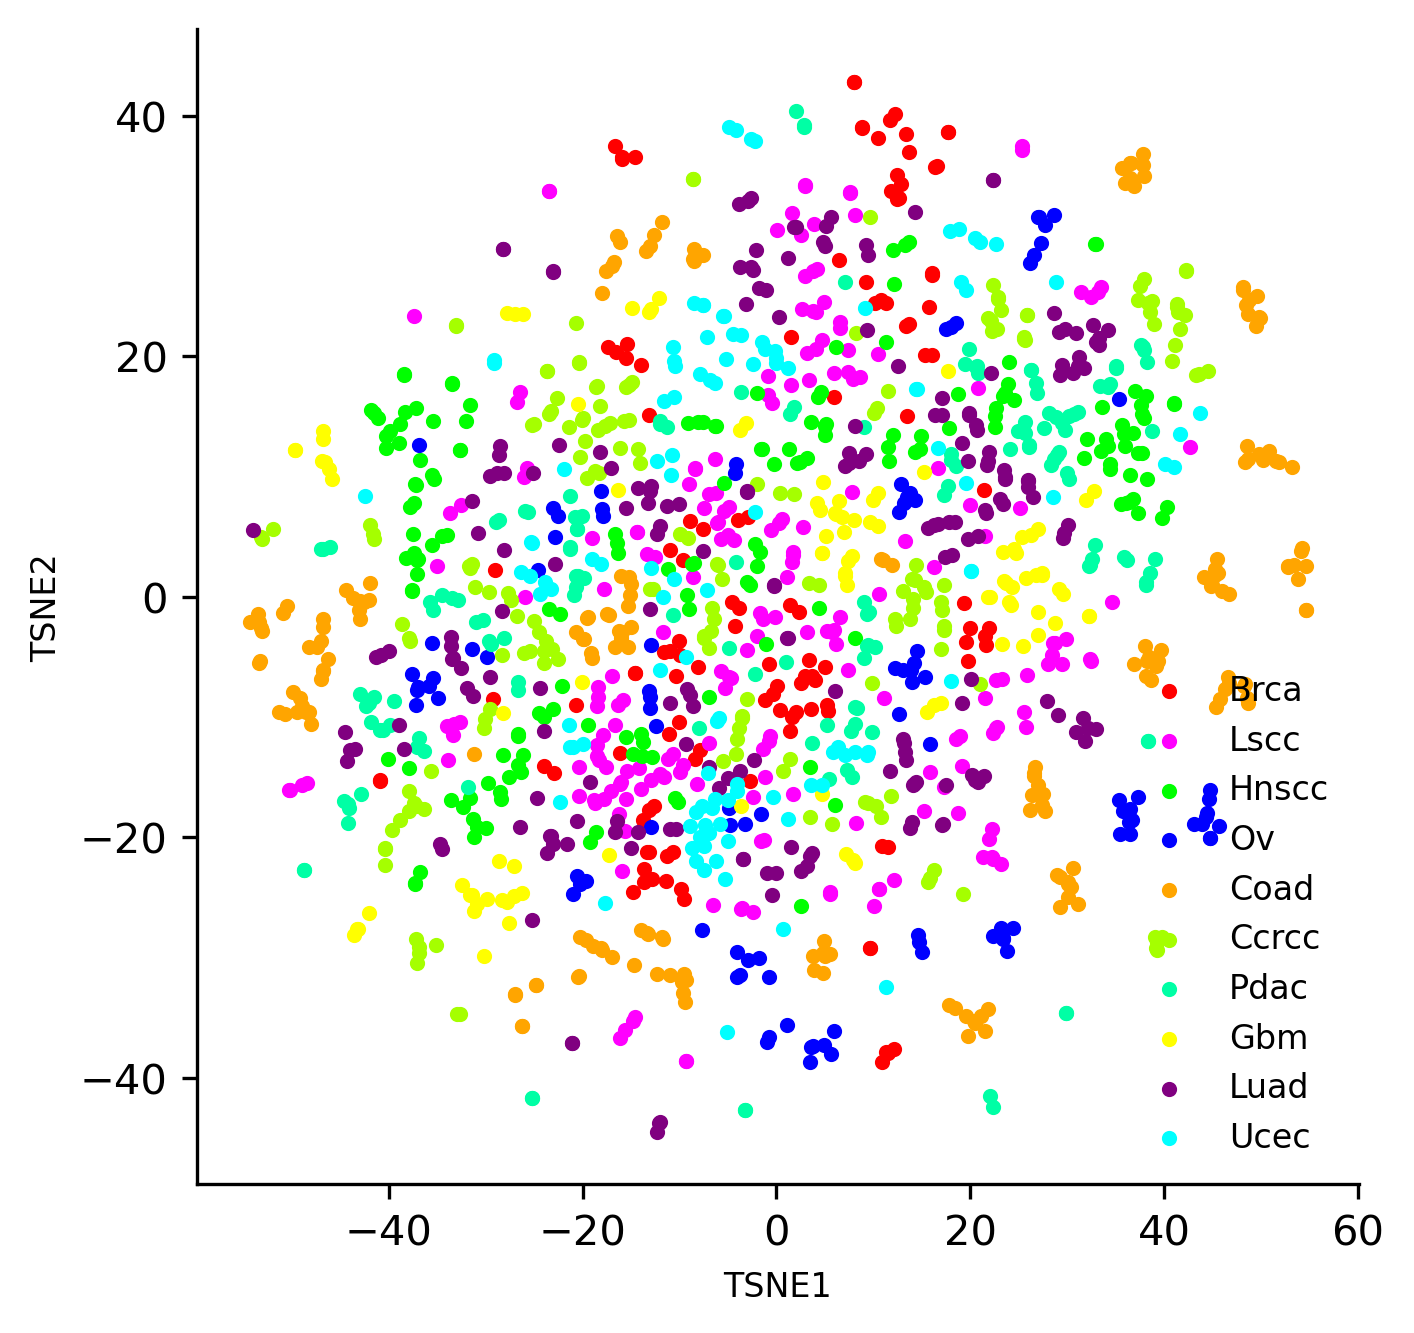

In [218]:
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
labels = np.array(tsne_df['label'])
# col = {0:'#1be7ff',1:'#ff5714'}

col = {cancer_type[0]:'#FF0000',cancer_type[1]:'#FF00FF',cancer_type[2]:'#00FF00',cancer_type[3]:'#0000FF',cancer_type[4]:'#FFA500',cancer_type[5]:'#A5FF00',cancer_type[6]:'#00FFA5',cancer_type[7]:'#FFFF00',cancer_type[8]:'#800080',cancer_type[9]:'#00FFFF'}

X_tsne = np.array(tsne_df[['TSNE1','TSNE2']])

for label, color in col.items():
    cluster_indices = np.where(labels == label)[0]
    cluster_X = X_tsne[cluster_indices]
    ax.scatter(cluster_X[:, 0], cluster_X[:, 1],s=7, c=color, label=label)

sns.despine()
y1=-10
# plt.plot([-40,40],[y1,y1])
plt.xlabel('TSNE1',fontsize=8)
plt.ylabel('TSNE2',fontsize=8)
plt.legend(loc='best',fontsize=8,frameon=False)
plt.show()

In [128]:
### for one cohort tumor vs normal

In [219]:
cancer_type

['Brca', 'Lscc', 'Hnscc', 'Ov', 'Coad', 'Ccrcc', 'Pdac', 'Gbm', 'Luad', 'Ucec']

In [246]:
merge_pro_df = pro_df_list_z[5].copy()
merge_pro_df

Name,PID,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZSCAN31,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,Cohort
0,C3L-00004,-1.486537,1.205398,-0.483810,-0.274630,0.453709,-0.949622,0.041150,-0.715054,0.685838,...,-0.783428,-0.475382,-0.738465,-0.969677,-0.099740,0.628791,-0.243646,-0.092786,-0.037770,Ccrcc
1,C3L-00010,1.382838,0.872220,1.492434,0.008244,-1.007507,-0.449840,-1.018606,0.186041,0.487283,...,0.078767,1.072044,0.042988,-0.881912,-0.074450,-0.505497,-0.073843,-0.613828,0.290563,Ccrcc
2,C3L-00011,-1.380202,-2.857165,-0.491216,-1.053758,2.532479,0.974696,-0.161544,-1.296259,3.373785,...,-0.473594,1.922894,3.501710,2.294562,-0.655050,1.788734,-0.127052,-0.993922,-2.660132,Ccrcc
3,C3L-00026,-0.673315,1.088976,-0.333629,-0.384897,0.327047,1.053883,-0.531654,1.444951,1.427595,...,-0.442302,0.093439,0.864379,1.334687,-0.774038,0.730023,-0.117862,-1.503703,-0.363551,Ccrcc
4,C3L-00079,-0.405715,-0.679918,-0.792575,-0.360109,0.842954,-0.369933,-0.558923,-0.328743,1.213241,...,0.330090,-0.253153,1.009689,0.413076,0.123617,-1.181199,1.006542,0.688104,-0.494107,Ccrcc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,C3N-01646.N,-0.569823,-0.164895,0.470958,-0.645837,-0.024091,1.633603,-1.521336,-0.857141,-0.082301,...,-0.576391,-2.293818,0.776730,-0.048180,-0.519088,-0.152238,-1.168532,-0.327639,-1.737433,Ccrcc
76,C3N-01648.N,-0.589715,-0.397808,-0.066099,-0.496015,-0.066478,-1.273676,0.401597,-0.597822,0.533698,...,-0.701326,1.050770,-0.611992,-0.716521,-0.182059,1.042223,-1.000796,0.386722,0.615227,Ccrcc
77,C3N-01649.N,0.953371,-0.328326,0.145117,-0.472809,0.807428,2.427085,1.235984,0.095575,-0.168117,...,-0.477718,0.189255,0.219903,0.512951,0.043406,0.943460,1.235140,-0.753437,1.357264,Ccrcc
78,C3N-01651.N,-0.354599,0.697919,-1.126358,-0.122930,1.339319,-0.385563,0.363389,0.252037,0.427513,...,-0.752120,1.443387,1.577775,1.260858,-0.000276,-1.356369,0.815091,0.065787,0.215395,Ccrcc


In [247]:
merge_pro_df['normal'] = [0 if ('NX' in x ) or ('.' in x) else 1 for x in merge_pro_df['PID']]
merge_pro_df

Name,PID,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,Cohort,normal
0,C3L-00004,-1.486537,1.205398,-0.483810,-0.274630,0.453709,-0.949622,0.041150,-0.715054,0.685838,...,-0.475382,-0.738465,-0.969677,-0.099740,0.628791,-0.243646,-0.092786,-0.037770,Ccrcc,1
1,C3L-00010,1.382838,0.872220,1.492434,0.008244,-1.007507,-0.449840,-1.018606,0.186041,0.487283,...,1.072044,0.042988,-0.881912,-0.074450,-0.505497,-0.073843,-0.613828,0.290563,Ccrcc,1
2,C3L-00011,-1.380202,-2.857165,-0.491216,-1.053758,2.532479,0.974696,-0.161544,-1.296259,3.373785,...,1.922894,3.501710,2.294562,-0.655050,1.788734,-0.127052,-0.993922,-2.660132,Ccrcc,1
3,C3L-00026,-0.673315,1.088976,-0.333629,-0.384897,0.327047,1.053883,-0.531654,1.444951,1.427595,...,0.093439,0.864379,1.334687,-0.774038,0.730023,-0.117862,-1.503703,-0.363551,Ccrcc,1
4,C3L-00079,-0.405715,-0.679918,-0.792575,-0.360109,0.842954,-0.369933,-0.558923,-0.328743,1.213241,...,-0.253153,1.009689,0.413076,0.123617,-1.181199,1.006542,0.688104,-0.494107,Ccrcc,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,C3N-01646.N,-0.569823,-0.164895,0.470958,-0.645837,-0.024091,1.633603,-1.521336,-0.857141,-0.082301,...,-2.293818,0.776730,-0.048180,-0.519088,-0.152238,-1.168532,-0.327639,-1.737433,Ccrcc,0
76,C3N-01648.N,-0.589715,-0.397808,-0.066099,-0.496015,-0.066478,-1.273676,0.401597,-0.597822,0.533698,...,1.050770,-0.611992,-0.716521,-0.182059,1.042223,-1.000796,0.386722,0.615227,Ccrcc,0
77,C3N-01649.N,0.953371,-0.328326,0.145117,-0.472809,0.807428,2.427085,1.235984,0.095575,-0.168117,...,0.189255,0.219903,0.512951,0.043406,0.943460,1.235140,-0.753437,1.357264,Ccrcc,0
78,C3N-01651.N,-0.354599,0.697919,-1.126358,-0.122930,1.339319,-0.385563,0.363389,0.252037,0.427513,...,1.443387,1.577775,1.260858,-0.000276,-1.356369,0.815091,0.065787,0.215395,Ccrcc,0


In [248]:
merge_pro_df['normal'].value_counts()

normal
1    103
0     80
Name: count, dtype: int64

In [249]:
# tsne_df = merged_pro_df.drop(['PID','Cohort'],axis=1)
tsne_df = merge_pro_df.drop(['PID','Cohort','normal'],axis=1)
tsne_df

Name,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADAT,AAGAB,AAK1,...,ZSCAN30,ZSCAN31,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1
0,-1.486537,1.205398,-0.483810,-0.274630,0.453709,-0.949622,0.041150,-0.715054,0.685838,0.019324,...,-0.531065,-0.783428,-0.475382,-0.738465,-0.969677,-0.099740,0.628791,-0.243646,-0.092786,-0.037770
1,1.382838,0.872220,1.492434,0.008244,-1.007507,-0.449840,-1.018606,0.186041,0.487283,0.877894,...,0.163382,0.078767,1.072044,0.042988,-0.881912,-0.074450,-0.505497,-0.073843,-0.613828,0.290563
2,-1.380202,-2.857165,-0.491216,-1.053758,2.532479,0.974696,-0.161544,-1.296259,3.373785,3.054425,...,0.735641,-0.473594,1.922894,3.501710,2.294562,-0.655050,1.788734,-0.127052,-0.993922,-2.660132
3,-0.673315,1.088976,-0.333629,-0.384897,0.327047,1.053883,-0.531654,1.444951,1.427595,-0.454708,...,0.051783,-0.442302,0.093439,0.864379,1.334687,-0.774038,0.730023,-0.117862,-1.503703,-0.363551
4,-0.405715,-0.679918,-0.792575,-0.360109,0.842954,-0.369933,-0.558923,-0.328743,1.213241,-0.085374,...,0.620004,0.330090,-0.253153,1.009689,0.413076,0.123617,-1.181199,1.006542,0.688104,-0.494107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.569823,-0.164895,0.470958,-0.645837,-0.024091,1.633603,-1.521336,-0.857141,-0.082301,-0.740949,...,-0.113504,-0.576391,-2.293818,0.776730,-0.048180,-0.519088,-0.152238,-1.168532,-0.327639,-1.737433
76,-0.589715,-0.397808,-0.066099,-0.496015,-0.066478,-1.273676,0.401597,-0.597822,0.533698,0.714456,...,-0.790358,-0.701326,1.050770,-0.611992,-0.716521,-0.182059,1.042223,-1.000796,0.386722,0.615227
77,0.953371,-0.328326,0.145117,-0.472809,0.807428,2.427085,1.235984,0.095575,-0.168117,0.268175,...,-0.611202,-0.477718,0.189255,0.219903,0.512951,0.043406,0.943460,1.235140,-0.753437,1.357264
78,-0.354599,0.697919,-1.126358,-0.122930,1.339319,-0.385563,0.363389,0.252037,0.427513,0.225126,...,0.744738,-0.752120,1.443387,1.577775,1.260858,-0.000276,-1.356369,0.815091,0.065787,0.215395


In [250]:
np.sum(np.sum(pd.isna(tsne_df)))

0

In [251]:
tsne = TSNE(n_components=2)
new_pro_mat = tsne.fit_transform(tsne_df)
tsne_df['TSNE1']=new_pro_mat[:,0]
tsne_df['TSNE2']=new_pro_mat[:,1]
# tsne_df['label'] = merged_pro_df['Cohort']
tsne_df['label'] = merge_pro_df['normal']

tsne_df

Name,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,AADAT,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,TSNE1,TSNE2,label
0,-1.486537,1.205398,-0.483810,-0.274630,0.453709,-0.949622,0.041150,-0.715054,0.685838,0.019324,...,-0.738465,-0.969677,-0.099740,0.628791,-0.243646,-0.092786,-0.037770,1.055835,-5.317148,1
1,1.382838,0.872220,1.492434,0.008244,-1.007507,-0.449840,-1.018606,0.186041,0.487283,0.877894,...,0.042988,-0.881912,-0.074450,-0.505497,-0.073843,-0.613828,0.290563,4.165399,-7.024427,1
2,-1.380202,-2.857165,-0.491216,-1.053758,2.532479,0.974696,-0.161544,-1.296259,3.373785,3.054425,...,3.501710,2.294562,-0.655050,1.788734,-0.127052,-0.993922,-2.660132,4.378084,11.503798,1
3,-0.673315,1.088976,-0.333629,-0.384897,0.327047,1.053883,-0.531654,1.444951,1.427595,-0.454708,...,0.864379,1.334687,-0.774038,0.730023,-0.117862,-1.503703,-0.363551,-11.262453,5.679224,1
4,-0.405715,-0.679918,-0.792575,-0.360109,0.842954,-0.369933,-0.558923,-0.328743,1.213241,-0.085374,...,1.009689,0.413076,0.123617,-1.181199,1.006542,0.688104,-0.494107,-5.468958,-2.115252,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,-0.569823,-0.164895,0.470958,-0.645837,-0.024091,1.633603,-1.521336,-0.857141,-0.082301,-0.740949,...,0.776730,-0.048180,-0.519088,-0.152238,-1.168532,-0.327639,-1.737433,5.081043,-4.207572,0
76,-0.589715,-0.397808,-0.066099,-0.496015,-0.066478,-1.273676,0.401597,-0.597822,0.533698,0.714456,...,-0.611992,-0.716521,-0.182059,1.042223,-1.000796,0.386722,0.615227,2.028155,3.358557,0
77,0.953371,-0.328326,0.145117,-0.472809,0.807428,2.427085,1.235984,0.095575,-0.168117,0.268175,...,0.219903,0.512951,0.043406,0.943460,1.235140,-0.753437,1.357264,-6.319220,10.405839,0
78,-0.354599,0.697919,-1.126358,-0.122930,1.339319,-0.385563,0.363389,0.252037,0.427513,0.225126,...,1.577775,1.260858,-0.000276,-1.356369,0.815091,0.065787,0.215395,-10.770160,15.310400,0


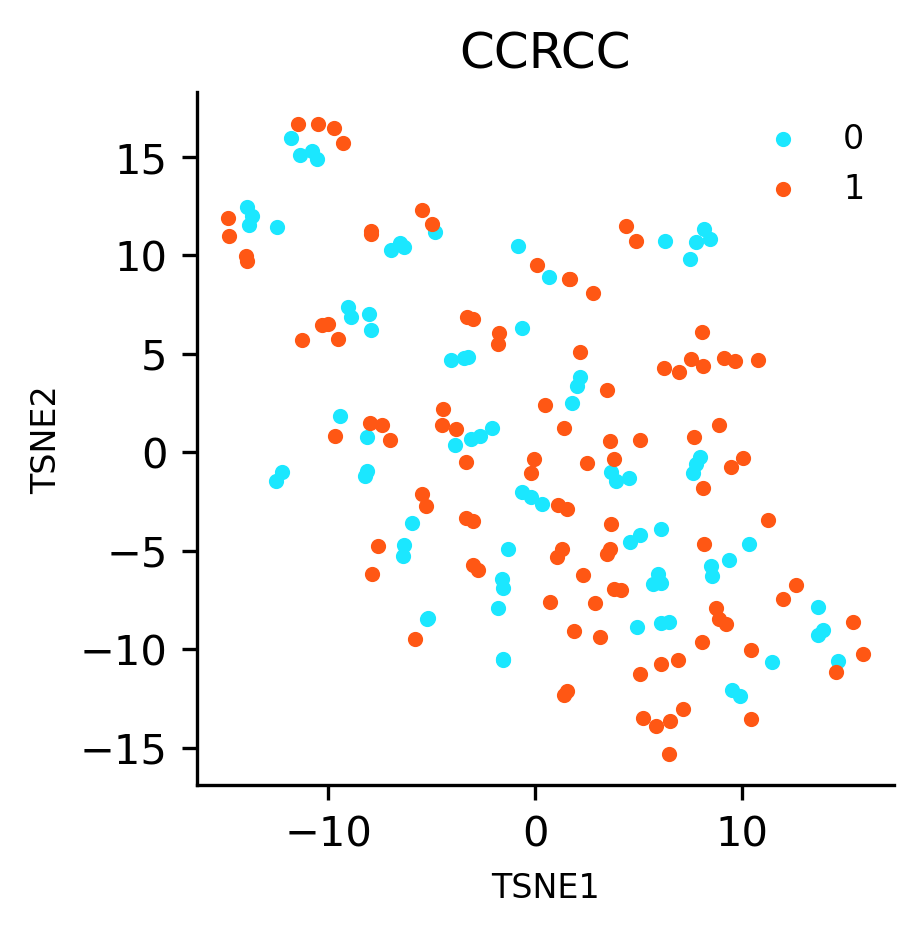

In [252]:
fig, ax = plt.subplots(figsize=(3,3),dpi=300)
labels = np.array(tsne_df['label'])
col = {0:'#1be7ff',1:'#ff5714'}

# col = {cancer_type[0]:'#FF0000',cancer_type[1]:'#FF00FF',cancer_type[2]:'#00FF00',cancer_type[3]:'#0000FF',cancer_type[4]:'#FFA500',cancer_type[5]:'#A5FF00',cancer_type[6]:'#00FFA5',cancer_type[7]:'#FFFF00',cancer_type[8]:'#800080',cancer_type[9]:'#00FFFF'}

X_tsne = np.array(tsne_df[['TSNE1','TSNE2']])

for label, color in col.items():
    cluster_indices = np.where(labels == label)[0]
    cluster_X = X_tsne[cluster_indices]
    ax.scatter(cluster_X[:, 0], cluster_X[:, 1],s=7, c=color, label=label)

sns.despine()
y1=-10
# plt.plot([-40,40],[y1,y1])
plt.xlabel('TSNE1',fontsize=8)
plt.ylabel('TSNE2',fontsize=8)
plt.legend(loc='best',fontsize=8,frameon=False)
plt.title('CCRCC')
plt.show()

# RNA part

In [11]:
cancer_type = ['Brca', 'Lscc', 'Hnscc', 'Ov', 'Coad', 'Ccrcc', 'Pdac', 'Gbm', 'Luad', 'Ucec']

In [12]:
brca = cptac.Brca()
lscc = cptac.Lscc()
hnscc = cptac.Hnscc()
ov = cptac.Ov()
coad = cptac.Coad()
ccrcc = cptac.Ccrcc()
pdac = cptac.Pdac()
gbm = cptac.Gbm()
luad = cptac.Luad()
ucec = cptac.Ucec()
cancer_data_list = [brca, lscc, hnscc, ov, coad, ccrcc, pdac, gbm, luad, ucec]

In [13]:
brca.get_transcriptomics('bcm')

Name,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,hsa-mir-1253,hsa-mir-423
Database_ID,ENSG00000121410.12,ENSG00000268895.6,ENSG00000148584.15,ENSG00000175899.15,ENSG00000245105.4,ENSG00000166535.20,ENSG00000256661.1,ENSG00000256904.1,ENSG00000256069.7,ENSG00000184389.9,...,ENSG00000198455.4,ENSG00000070476.15,ENSG00000203995.10,ENSG00000232242.2,ENSG00000162378.13,ENSG00000159840.16,ENSG00000274572.1,ENSG00000074755.15,ENSG00000272920.1,ENSG00000266919.3
Patient_ID,,,,,,,,,,,,,,,,,,,,,
01BR001,3.51,8.04,0.00,12.93,5.01,4.88,0.0,0.0,3.13,0.00,...,9.02,8.88,7.07,0.0,9.86,10.63,0.0,10.05,0.0,0.0
01BR008,2.84,8.24,2.50,13.02,5.67,10.10,0.0,0.0,0.00,0.00,...,7.93,8.84,8.60,0.0,8.44,11.36,0.0,10.20,0.0,0.0
01BR009,4.85,8.11,0.00,13.68,5.87,9.50,0.0,0.0,3.11,0.00,...,7.53,8.85,3.64,0.0,8.90,10.58,0.0,10.54,0.0,0.0
01BR010,4.24,7.96,0.00,12.64,4.82,5.03,0.0,0.0,1.33,0.00,...,8.53,8.31,8.28,0.0,9.28,12.40,0.0,10.42,0.0,0.0
01BR015,3.89,7.56,1.58,13.55,5.32,3.31,0.0,0.0,2.99,0.00,...,9.17,9.05,5.08,0.0,10.13,10.44,0.0,10.46,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21BR002,0.00,7.86,0.00,13.96,6.51,1.12,0.0,0.0,0.00,1.74,...,7.40,9.79,5.47,0.0,8.97,11.72,0.0,10.18,0.0,0.0
21BR010,3.50,6.83,1.43,14.57,6.76,0.00,0.0,0.0,3.49,0.00,...,10.31,9.14,4.63,0.0,11.22,8.95,0.0,10.19,0.0,0.0


In [14]:
rna_df_list = []
for i in range(len(cancer_data_list)):
    one_c = cancer_data_list[i]
    one_rna = one_c.get_transcriptomics('bcm').copy()
    one_rna.columns = one_rna.columns.droplevel(1)
    rna_df_list.append(one_rna)
    print(cancer_type[i], one_rna.shape)

Brca (133, 60591)


Lscc (211, 59286)


Hnscc (170, 59286)


Ov (101, 60591)


Coad (106, 60591)


Ccrcc (185, 59286)


Pdac (212, 59286)


Gbm (100, 59286)


Luad (213, 59286)
Ucec (119, 59286)


In [20]:
for i in range(len(cancer_data_list)):
    one_c = cancer_data_list[i]
    one_rna = rna_df_list[i]
    na_count = np.sum(np.sum(pd.isna(one_rna)))
    print(cancer_type[i], na_count)

Brca 0
Lscc 0
Hnscc 0
Ov 0
Coad 0
Ccrcc 0
Pdac 0
Gbm 0
Luad 0
Ucec 0


# Merge all cancer data

In [15]:
rna_dict = {}
for i in range(len(rna_df_list)):
    tmp_df = rna_df_list[i]
    sam_n = tmp_df.shape[0]
    rna_l = set(tmp_df.columns.tolist())
    ch_name = cancer_type[i]+'_'+str(sam_n)
    rna_dict[ch_name] = rna_l


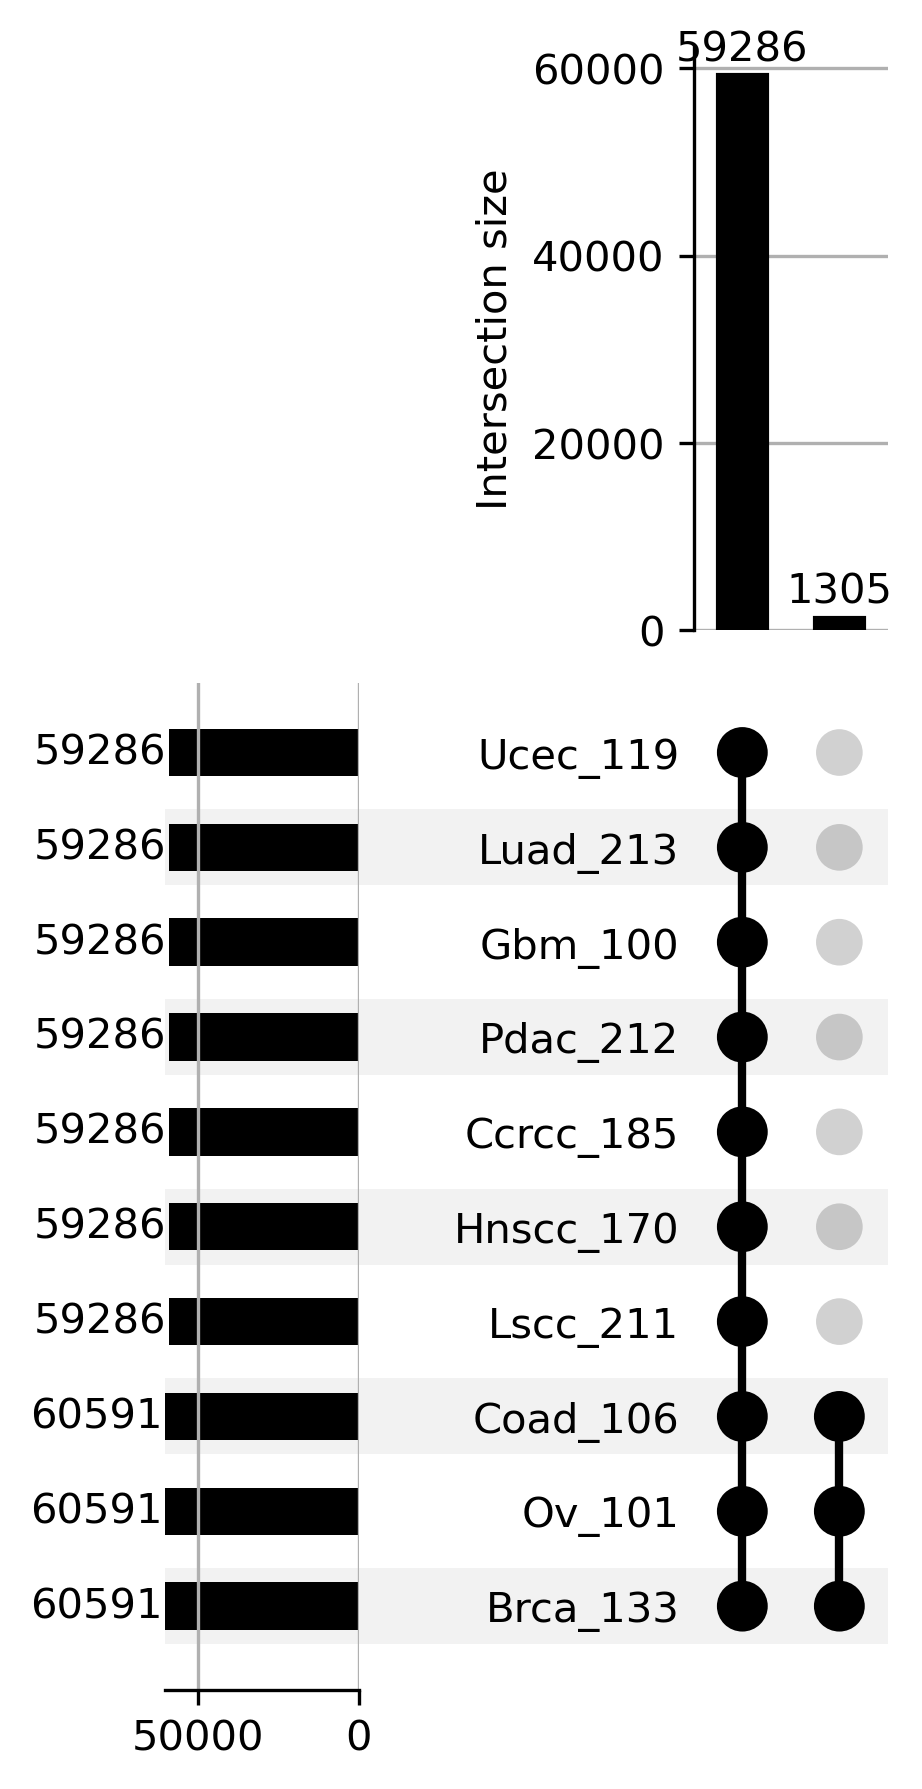

In [16]:
fig = plt.figure(figsize=(10, 15),dpi=300)
df = from_contents(rna_dict)
upset = UpSet(df,sort_by='cardinality',show_counts='%d',min_subset_size=100)
upset.style_subsets(max_degree=1,
                    facecolor="blue")
upset.plot(fig=fig)
plt.show()

# Normalization and merge data

In [21]:
cg_rna_df = pd.read_csv('./../rna_z_log2_quantile.csv')
cg_rna_df

,PID,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,AAAS,...,ZYG11B,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-125a,hsa-mir-335,hsa-mir-6080,hsa-mir-6723,hsa-mir-8072
0,2103,1.055387,0.575329,0.055275,-0.882739,-1.179203,-0.806755,-0.622030,-0.394622,-0.028524,...,-0.446678,1.729788,-0.861288,0.272212,-1.046022,-0.573000,-0.369064,-0.749739,-0.909866,-0.504186
1,P100,1.624750,1.150390,0.492595,-0.922213,-1.012854,-0.228219,4.646971,0.231277,-0.206414,...,-1.176904,0.884542,-0.578044,0.271288,0.956426,-0.124392,0.028803,1.046818,-0.374046,1.378179
2,P103,-0.475752,0.408501,-0.540062,-0.777315,0.847218,-0.454825,-0.228431,-1.190059,0.618382,...,0.053083,-0.965375,0.924726,-0.654926,-0.083318,-0.342720,0.256371,0.843151,-0.491450,1.180257
3,P106,1.154665,1.130899,0.282414,-0.296998,-1.432991,0.463650,3.143506,0.173087,0.583407,...,-2.156994,2.238059,0.320553,-2.493571,-0.341913,-0.043212,-0.416480,1.910922,-0.001757,0.057779
4,P109,1.984589,0.978914,-0.184410,-0.454219,-1.284374,-0.407106,3.166982,1.451217,1.655679,...,-1.738329,0.536346,-0.543587,-1.258677,1.180613,0.032970,0.409755,1.152817,-0.503810,3.247054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,P969,-0.042382,0.875755,-0.339478,1.364071,0.070977,-0.702865,0.055038,-0.279749,-1.608915,...,2.591636,-0.853023,-0.326448,0.478875,-0.117108,-0.743852,-0.453727,-0.823027,0.096788,-1.703235
107,P978,-0.886915,-0.733486,-0.042746,-1.203139,0.278861,-0.806755,0.011150,-0.021850,-0.274356,...,0.603409,-0.581259,1.008744,-0.753347,-1.068001,-0.525076,-0.282634,-0.612380,-0.417863,-1.179209
108,P981,0.069953,1.056638,-1.637522,-0.447815,-0.210092,-0.806755,-0.622030,-1.377847,0.440510,...,0.497902,-0.658379,-1.028201,-1.208788,-1.105884,1.162115,-0.498969,-0.775401,1.353601,0.597915
109,P999,-0.745680,1.390354,-0.588026,0.923492,0.016569,-0.409416,-0.622030,0.621025,-1.957425,...,2.291495,-0.702017,-0.609897,-0.098598,0.486822,-0.834504,-0.498969,-1.401750,1.195909,-1.563500


In [22]:
gene_name = cg_rna_df.columns[1:].tolist()
len(gene_name)

23094

In [28]:
rna_df_list_z = []
for i in range(len(rna_df_list)):
    tmp_df = rna_df_list[i]
    col = tmp_df.columns.tolist()
    new_col = list(set(col).intersection(set(gene_name)))
    tmp_df = tmp_df[new_col]
    new_df_z = get_all_process_df(tmp_df)
    rna_df_list_z.append(new_df_z)
    print(cancer_type[i], new_df_z.shape)

Brca (133, 17568)
Lscc (211, 17560)
Hnscc (170, 17560)
Ov (101, 17568)
Coad (106, 17568)
Ccrcc (185, 17560)
Pdac (212, 17560)
Gbm (100, 17560)
Luad (213, 17560)
Ucec (119, 17560)


In [29]:
rna_df_list_z[0].head()

Name,PID,SEPHS1P1,DTNA,LRRC14,ZNF175,FAM83F,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,01BR001,-0.142061,0.801984,-0.243720,-0.957052,0.801506,-0.453677,0.664105,-0.928307,0.313982,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,01BR008,-0.522927,0.048269,1.257051,-0.409207,0.364911,1.321845,-0.132178,1.929827,-1.765043,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,01BR009,-0.757746,-0.909189,2.143081,0.671909,0.624309,-0.126880,0.401980,0.295191,-0.086535,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,01BR010,2.322544,1.135619,0.225283,0.379154,-0.341652,2.744908,0.257609,-0.742465,0.727750,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,01BR015,1.337895,-1.674885,0.725246,0.365833,0.188074,0.147382,-0.974799,-0.942094,0.626817,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121


In [30]:
shared_rna_list = []
for i in range(len(rna_df_list_z)):
    tmp_df = rna_df_list_z[i]
    sam_n = tmp_df.shape[0]
    rna_l = set(tmp_df.columns[1:].tolist())
    if i == 0:
        shared_rna_list = rna_l
    shared_rna_list = shared_rna_list.intersection(rna_l)
shared_rna_list = list(shared_rna_list)
print(len(shared_rna_list))

17559


In [31]:
merged_rna_df = pd.DataFrame()
for i in range(len(rna_df_list_z)):
    tmp_df = rna_df_list_z[i]
    sam_n = tmp_df.shape[0]
    ch_name = cancer_type[i]
    tmp_df['Cohort'] = ch_name
    new_df = tmp_df[['PID','Cohort']+shared_rna_list]
    merged_rna_df = pd.concat([merged_rna_df,new_df],axis=0)
merged_rna_df.shape

(1550, 17561)

In [32]:
merged_rna_df.to_csv('./../CPTAC_pancancer/Pretrain/merged_rna_cohort_df.csv',index=False)

In [33]:
merged_rna_mat = merged_rna_df.drop(['Cohort'],axis=1)
merged_rna_mat

Name,PID,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,01BR001,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,01BR008,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,01BR009,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,01BR010,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,01BR015,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,C3N-00383.N,-0.970962,1.536094,0.097055,-0.501855,1.590722,0.542948,-0.675533,-0.444170,0.674633,...,0.618605,1.658966,-1.248219,0.938751,-0.781634,-0.527287,0.622128,-1.036256,-2.102954,-1.190504
115,C3N-00858.N,0.711407,0.976941,-0.096701,-1.592962,1.141874,0.127307,0.923950,-0.908942,0.887200,...,1.632948,0.291029,0.751364,1.072583,-1.564922,-1.330769,2.472866,-1.700299,-0.647734,-2.355914
116,C3N-00866.N,-2.582382,1.164329,0.257010,-1.895657,0.493881,3.071921,-0.667414,-0.810568,-0.722727,...,1.020164,0.895737,1.944987,1.501332,-0.417002,-0.554274,2.333428,-1.260737,-0.899192,-2.428323
117,C3N-01003.N,0.476313,1.313192,0.274208,-1.142831,1.567276,1.862834,-0.675533,-1.095478,0.226105,...,1.352648,0.791487,0.545890,1.766223,0.175193,-0.169310,1.461100,-1.364136,-0.723980,-2.184825


In [34]:
merged_rna_mat.to_csv('./../CPTAC_pancancer/Pretrain/merged_rna_df.csv',index=False)

# TSNE

In [36]:
tsne_df = merged_rna_df.drop(['PID','Cohort'],axis=1)
tsne_df

Name,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,F10,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,-1.871170,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,-0.133672,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,-0.290830,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,-1.578658,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,0.655222,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-0.970962,1.536094,0.097055,-0.501855,1.590722,0.542948,-0.675533,-0.444170,0.674633,1.029665,...,0.618605,1.658966,-1.248219,0.938751,-0.781634,-0.527287,0.622128,-1.036256,-2.102954,-1.190504
115,0.711407,0.976941,-0.096701,-1.592962,1.141874,0.127307,0.923950,-0.908942,0.887200,2.062283,...,1.632948,0.291029,0.751364,1.072583,-1.564922,-1.330769,2.472866,-1.700299,-0.647734,-2.355914
116,-2.582382,1.164329,0.257010,-1.895657,0.493881,3.071921,-0.667414,-0.810568,-0.722727,1.899591,...,1.020164,0.895737,1.944987,1.501332,-0.417002,-0.554274,2.333428,-1.260737,-0.899192,-2.428323
117,0.476313,1.313192,0.274208,-1.142831,1.567276,1.862834,-0.675533,-1.095478,0.226105,1.743993,...,1.352648,0.791487,0.545890,1.766223,0.175193,-0.169310,1.461100,-1.364136,-0.723980,-2.184825


In [37]:
np.sum(np.sum(pd.isna(tsne_df)))

0

In [38]:
tsne = TSNE(n_components=2)
new_rna_mat = tsne.fit_transform(tsne_df)
tsne_df['TSNE1']=new_rna_mat[:,0]
tsne_df['TSNE2']=new_rna_mat[:,1]
tsne_df['label'] = merged_rna_df['Cohort']

tsne_df

Name,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,F10,...,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4,TSNE1,TSNE2,label
0,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,-1.871170,...,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778,14.764187,0.523686,Brca
1,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,-0.133672,...,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592,28.494089,15.628476,Brca
2,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,-0.290830,...,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085,-10.947938,-4.049247,Brca
3,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,-1.578658,...,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001,-1.256416,-19.484886,Brca
4,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,0.655222,...,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121,-6.057085,6.307690,Brca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-0.970962,1.536094,0.097055,-0.501855,1.590722,0.542948,-0.675533,-0.444170,0.674633,1.029665,...,0.938751,-0.781634,-0.527287,0.622128,-1.036256,-2.102954,-1.190504,-36.750084,-11.835921,Ucec
115,0.711407,0.976941,-0.096701,-1.592962,1.141874,0.127307,0.923950,-0.908942,0.887200,2.062283,...,1.072583,-1.564922,-1.330769,2.472866,-1.700299,-0.647734,-2.355914,-38.109406,-11.169323,Ucec
116,-2.582382,1.164329,0.257010,-1.895657,0.493881,3.071921,-0.667414,-0.810568,-0.722727,1.899591,...,1.501332,-0.417002,-0.554274,2.333428,-1.260737,-0.899192,-2.428323,-39.157856,-11.928957,Ucec
117,0.476313,1.313192,0.274208,-1.142831,1.567276,1.862834,-0.675533,-1.095478,0.226105,1.743993,...,1.766223,0.175193,-0.169310,1.461100,-1.364136,-0.723980,-2.184825,-37.450390,-11.737919,Ucec


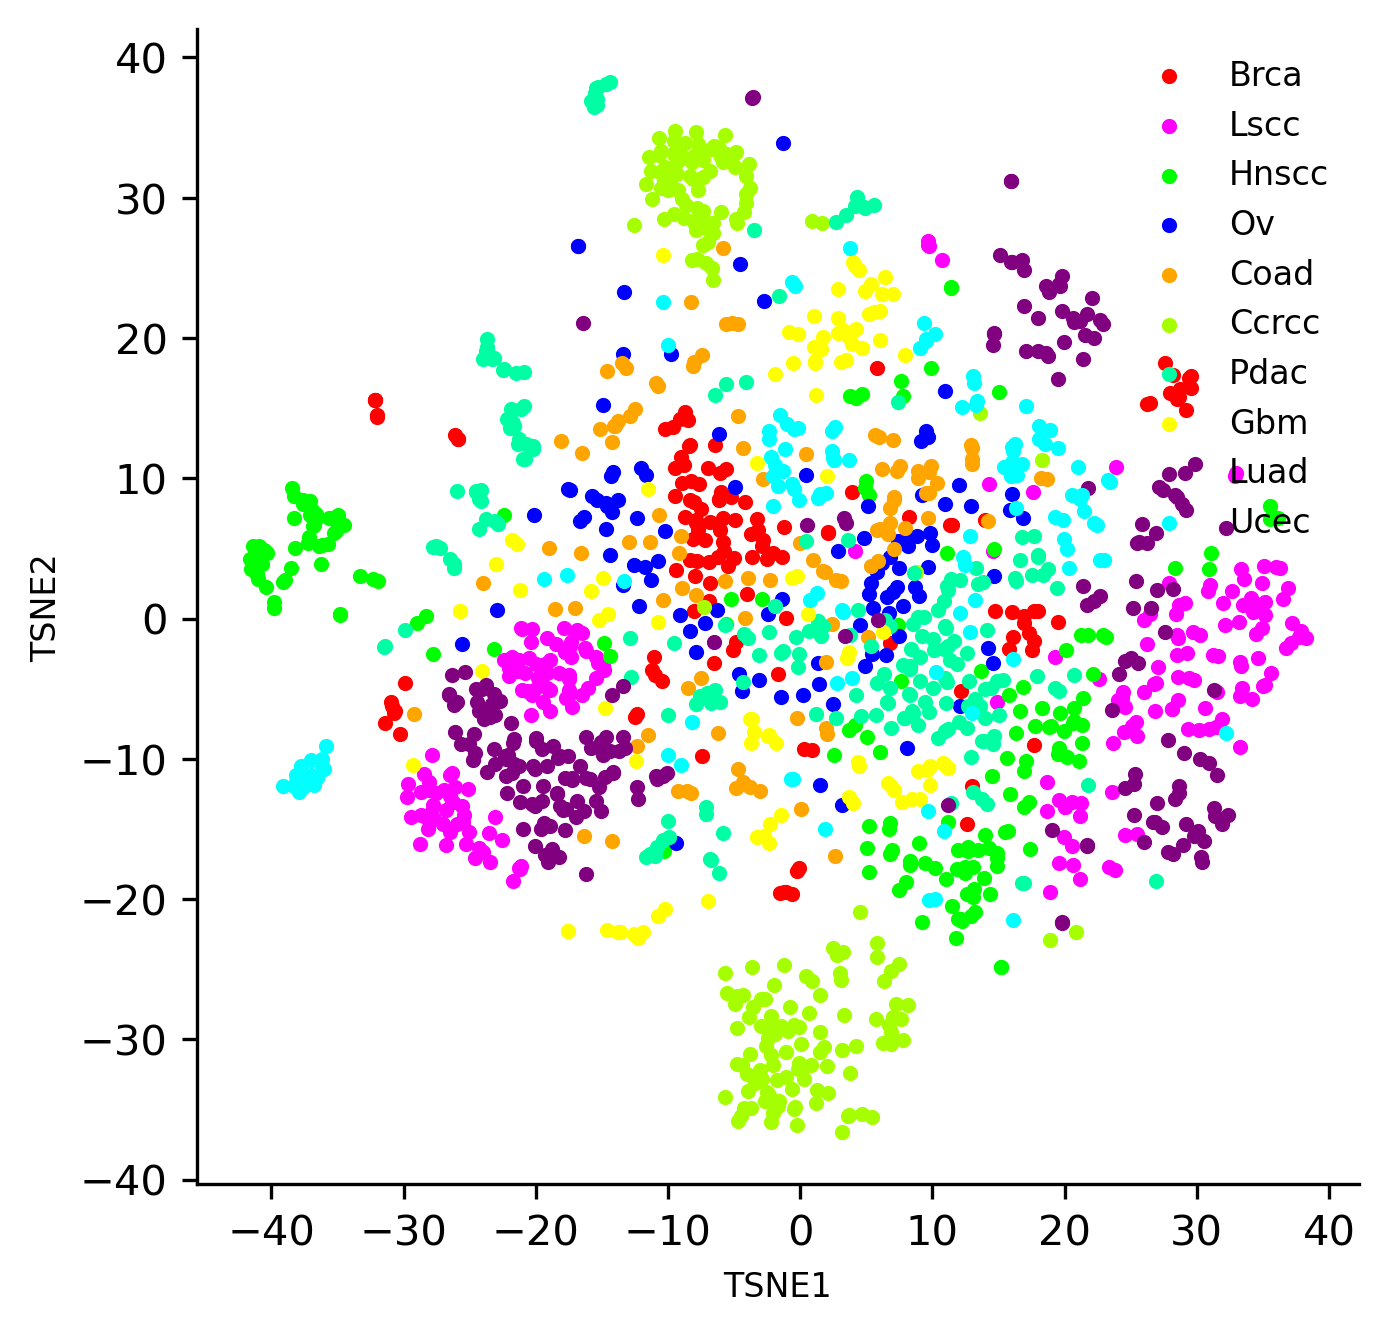

In [39]:
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
labels = np.array(tsne_df['label'])
# col = {0:'#1be7ff',1:'#ff5714'}

col = {cancer_type[0]:'#FF0000',cancer_type[1]:'#FF00FF',cancer_type[2]:'#00FF00',cancer_type[3]:'#0000FF',cancer_type[4]:'#FFA500',cancer_type[5]:'#A5FF00',cancer_type[6]:'#00FFA5',cancer_type[7]:'#FFFF00',cancer_type[8]:'#800080',cancer_type[9]:'#00FFFF'}

X_tsne = np.array(tsne_df[['TSNE1','TSNE2']])

for label, color in col.items():
    cluster_indices = np.where(labels == label)[0]
    cluster_X = X_tsne[cluster_indices]
    ax.scatter(cluster_X[:, 0], cluster_X[:, 1],s=7, c=color, label=label)

sns.despine()
y1=-10
# plt.plot([-40,40],[y1,y1])
plt.xlabel('TSNE1',fontsize=8)
plt.ylabel('TSNE2',fontsize=8)
plt.legend(loc='best',fontsize=8,frameon=False)
plt.show()

# Protein and RNA overlap data

In [43]:
merge_pro_mat = pd.read_csv('./../CPTAC_pancancer/Pretrain/merged_pro_df.csv')
merge_pro_mat

,PID,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,01BR001,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,...,0.917994,-1.365615,-0.218110,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754
1,01BR008,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,...,-0.364908,-0.637128,-0.206555,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492
2,01BR009,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,...,0.900607,0.617207,0.622614,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971
3,01BR010,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,...,-0.246015,0.893164,0.823663,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842
4,01BR015,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,...,0.417653,0.392018,0.906453,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,NX10,-0.970949,0.927515,-0.441864,-0.687578,1.133735,-0.890225,0.452179,0.786106,-0.238070,...,0.627781,-0.113712,0.775392,-0.716412,1.610838,-1.129755,-1.018968,-0.278560,-0.260703,1.080986
1545,NX16,-0.343485,0.217685,-0.889214,0.488336,0.402929,-0.279217,0.866932,-0.617793,-0.251701,...,1.189584,-0.406077,-0.424346,-0.883768,1.520969,-1.085067,-0.244732,-0.680381,-0.481476,0.185272
1546,NX18,-0.258244,0.195290,-0.173148,-0.174214,-0.181438,0.296693,0.113486,-0.266258,-0.318079,...,0.875791,0.347956,0.357953,-0.706914,0.928833,-1.027306,-0.297889,1.487797,0.060109,-0.018510
1547,NX11,-0.950491,1.884100,0.224693,-0.043332,-0.429293,-0.020788,0.063377,-0.451420,-0.199369,...,1.368443,1.044459,0.104604,-0.421099,1.578959,-1.266199,-0.598630,0.856165,-0.239782,0.096446


In [45]:
merge_rna_mat = pd.read_csv('./../CPTAC_pancancer/Pretrain/merged_rna_df.csv')
merge_rna_mat

,PID,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,01BR001,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,01BR008,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,01BR009,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,01BR010,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,01BR015,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,C3N-00383.N,-0.970962,1.536094,0.097055,-0.501855,1.590722,0.542948,-0.675533,-0.444170,0.674633,...,0.618605,1.658966,-1.248219,0.938751,-0.781634,-0.527287,0.622128,-1.036256,-2.102954,-1.190504
1546,C3N-00858.N,0.711407,0.976941,-0.096701,-1.592962,1.141874,0.127307,0.923950,-0.908942,0.887200,...,1.632948,0.291029,0.751364,1.072583,-1.564922,-1.330769,2.472866,-1.700299,-0.647734,-2.355914
1547,C3N-00866.N,-2.582382,1.164329,0.257010,-1.895657,0.493881,3.071921,-0.667414,-0.810568,-0.722727,...,1.020164,0.895737,1.944987,1.501332,-0.417002,-0.554274,2.333428,-1.260737,-0.899192,-2.428323
1548,C3N-01003.N,0.476313,1.313192,0.274208,-1.142831,1.567276,1.862834,-0.675533,-1.095478,0.226105,...,1.352648,0.791487,0.545890,1.766223,0.175193,-0.169310,1.461100,-1.364136,-0.723980,-2.184825


In [46]:
pid_pro = merge_pro_mat['PID'].tolist()
pid_rna = merge_rna_mat['PID'].tolist()
pid_shared = list(set(pid_pro).intersection(set(pid_rna)))
len(pid_shared)

1351

In [56]:
merge_pro_mat = merge_pro_mat[merge_pro_mat['PID'].isin(pid_shared)]
merge_pro_mat

,PID,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,01BR001,-1.770712,0.232097,0.362590,0.240962,0.018081,-0.615816,-0.561280,1.864918,1.601994,...,0.917994,-1.365615,-0.218110,2.039493,1.930702,0.590657,-0.128781,-0.276275,-0.300053,0.197754
1,01BR008,-0.491710,1.206229,0.341243,-0.606647,-0.613793,1.177300,-0.635790,-0.822496,-0.467617,...,-0.364908,-0.637128,-0.206555,-0.648819,-1.291194,0.361452,-1.257755,0.789682,0.700124,-0.602492
2,01BR009,-2.028142,-0.784486,-0.334785,-0.117687,0.277103,-0.283694,-0.490647,-0.514231,0.990771,...,0.900607,0.617207,0.622614,-0.639923,-0.908674,2.022072,-1.091776,-0.526402,-0.544839,0.642971
3,01BR010,-0.134458,-0.751096,1.845895,-0.079038,0.687127,0.880149,0.850907,1.089011,0.490555,...,-0.246015,0.893164,0.823663,-0.943663,1.753902,0.495991,-0.552424,-0.736164,-0.184654,1.492842
4,01BR015,-0.752249,1.144137,0.587811,0.203944,-0.359459,0.527271,0.573433,0.816252,1.546575,...,0.417653,0.392018,0.906453,0.762420,1.284425,1.575414,-0.046582,-0.415283,0.222208,0.753946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,C3N-01802,0.339980,-0.503277,0.177620,0.475843,1.498588,0.952446,-1.002689,-2.068763,0.517207,...,-1.403114,-0.141867,0.610713,1.424664,1.116272,-1.324950,-1.925131,-1.008027,-0.397028,0.690908
1527,C3N-00151,-1.053194,0.364532,-0.610684,2.116971,1.530965,0.412934,1.069029,1.021417,0.429217,...,-0.678216,-1.149004,-0.704998,0.944980,0.759826,-0.870110,-2.374410,0.885915,-0.524607,0.534795
1528,C3L-00136,3.038898,-0.447753,1.230286,1.205754,-0.002954,-1.889901,1.803642,0.402657,0.673881,...,-1.520456,-0.510281,1.144278,0.507073,0.990929,-1.448517,0.138465,-1.067612,-2.069040,-0.488738
1529,C3L-00008,-0.893853,0.960992,-0.420536,0.699856,0.163460,0.810364,0.861159,-0.335140,0.904480,...,-1.001074,0.327380,-0.243044,0.667707,0.529117,-1.332895,-0.919253,0.902467,-0.090269,0.504022


In [57]:
merge_rna_mat = merge_rna_mat[merge_rna_mat['PID'].isin(pid_shared)]
merge_rna_mat

,PID,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,01BR001,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,01BR008,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,01BR009,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,01BR010,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,01BR015,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,C3N-01520,0.540821,0.183630,-0.075824,0.525234,-0.048365,-0.274627,-0.675533,-0.504355,-0.994344,...,0.192776,-0.209616,1.649139,-0.265390,0.896074,-0.757219,-0.877211,0.247994,2.248327,0.347776
1531,C3N-01521,1.869801,-1.105545,3.937374,-0.157036,-1.123304,-0.565476,-0.675533,-0.584688,-0.907542,...,-0.790453,0.010603,-0.509812,-0.241341,0.895214,0.327746,-0.873335,-0.409348,3.521275,0.632957
1532,C3N-01537,-2.587614,0.382894,-1.183383,-0.682250,-0.875627,-1.206429,0.028568,-0.022126,-1.215365,...,-0.053120,-1.353303,-1.253531,-0.034295,1.396843,1.439386,-1.007264,1.218791,-1.204689,0.215169
1533,C3N-01802,-1.095120,-0.601407,-0.681547,0.558328,-0.730803,1.220025,0.773575,-0.279444,-0.926761,...,4.424304,0.290357,-0.610089,-0.090930,0.295065,-0.463611,-0.244386,0.340784,0.113313,-0.654895


In [58]:
merge_rna_mat = merge_pro_mat[['PID']].merge(merge_rna_mat, on='PID', how='left')
merge_rna_mat

,PID,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,01BR001,-0.142061,0.801984,-0.243720,0.801506,-0.957052,-0.453677,0.664105,-0.928307,0.313982,...,0.309770,-2.172808,0.530533,1.005080,-0.349806,-0.656723,0.121342,0.473220,0.066052,1.622778
1,01BR008,-0.522927,0.048269,1.257051,0.364911,-0.409207,1.321845,-0.132178,1.929827,-1.765043,...,0.892183,-2.172808,-0.544286,1.733047,-1.264089,0.355448,-1.484772,-0.698083,0.447520,0.430592
2,01BR009,-0.757746,-0.909189,2.143081,0.624309,0.671909,-0.126880,0.401980,0.295191,-0.086535,...,1.023393,-1.247769,-0.791144,0.237454,-0.465446,0.974708,-0.548660,0.871786,1.019095,0.638085
3,01BR010,2.322544,1.135619,0.225283,-0.341652,0.379154,2.744908,0.257609,-0.742465,0.727750,...,1.073332,-0.392297,0.275184,-1.082453,-1.259853,1.606549,0.186229,1.007862,-0.278201,0.331001
4,01BR015,1.337895,-1.674885,0.725246,0.188074,0.365833,0.147382,-0.974799,-0.942094,0.626817,...,-0.375862,0.007533,0.796401,-0.134591,-0.088903,-0.091211,1.070687,2.241593,-1.405192,0.852121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,C3N-01802,-1.095120,-0.601407,-0.681547,0.558328,-0.730803,1.220025,0.773575,-0.279444,-0.926761,...,4.424304,0.290357,-0.610089,-0.090930,0.295065,-0.463611,-0.244386,0.340784,0.113313,-0.654895
1347,C3N-00151,0.349883,-0.738761,0.033629,-1.896273,-0.056566,-0.298043,0.783210,-0.462781,-0.789286,...,-0.047253,-0.555623,0.112381,0.486237,-0.937188,-0.300455,-1.472907,1.011062,0.942263,0.456224
1348,C3L-00136,0.133618,-1.640806,-0.099385,1.234435,0.125308,-1.194863,-0.675533,3.953026,2.978528,...,0.828585,-0.938133,-1.272485,-1.534987,0.848820,0.417872,0.186270,-0.807773,0.206887,-0.097042
1349,C3L-00008,0.104727,-0.584297,0.226987,-0.216471,-0.519405,1.366521,-0.494065,-1.051766,-0.421337,...,-0.368002,0.698137,1.914491,1.051594,1.038731,0.499528,-0.229799,0.187407,1.254178,0.591141


In [59]:
merge_pro_mat.to_csv('./../CPTAC_pancancer/pro_rna_olp/merged_pro_overlap_df.csv',index=False)
merge_rna_mat.to_csv('./../CPTAC_pancancer/pro_rna_olp/merged_rna_overlap_df.csv',index=False)

In [61]:
gene_list = merge_rna_mat.columns[1:].tolist()
print(len(gene_list))
pro_list = merge_pro_mat.columns[1:].tolist()
len(pro_list)

17559


7754

In [67]:
gene_df = pd.DataFrame(gene_list,columns=['gene'])
pro_df = pd.DataFrame(pro_list,columns=['pro'])
gene_df.to_csv('./../CPTAC_pancancer/pro_rna_olp/gene_list.csv',index=False)
pro_df.to_csv('./../CPTAC_pancancer/pro_rna_olp/pro_list.csv',index=False)

# Other cohort get the same gene and pro list

In [71]:
gene_df = pd.read_csv('./../CPTAC_pancancer/pro_rna_olp/gene_list.csv')
pro_df = pd.read_csv('./../CPTAC_pancancer/pro_rna_olp/pro_list.csv')
gene_list = gene_df['gene'].tolist()
pro_list = pro_df['pro'].tolist()

## For protein data

In [131]:
one_pro_df= pd.read_csv('./../test_pro_df.csv')
one_pro_df

,PID,FER1L5,UBA6,SHTN1,ILVBL,SH3PXD2B,PPIA,NBAS,TARSL2,VWA8,...,ROBO1,NUMBL,SLC4A4,FCGBP,DGKB,SCIN,PCLO,WASF2,FAM169A,SEC23IP
0,1-1,-0.03727,0.14117,0.08398,0.12127,0.32608,0.02985,0.27209,-0.01472,-0.01188,...,0.23479,-0.01656,-0.68878,0.72573,-0.03705,0.69929,0.00727,-0.00026,0.11519,-0.05825
1,1-2,-0.47862,-0.02289,0.31917,0.16432,-0.21243,0.03071,-0.10034,-0.30765,-0.17202,...,0.03400,0.14096,-0.31211,-0.92763,1.10509,-0.34280,0.78795,0.04923,-0.14165,-0.45893
2,10,0.13801,-0.08384,-0.93113,0.01068,0.16322,0.17070,-0.17382,-0.36873,-0.23127,...,-0.19853,-0.02222,0.20703,0.01076,-0.41235,-0.02821,-0.00727,0.00026,-0.08768,-0.03530
3,11,0.33335,0.07663,-0.26270,-0.01068,-0.09880,0.01301,-0.04707,-0.14629,-0.12270,...,-0.00407,0.15332,-0.50735,0.74468,-0.23799,0.59421,-0.01038,-0.15844,-0.28959,-0.01525
4,12,-0.14754,0.40142,0.33837,0.38274,-0.36317,0.30300,0.40697,0.49805,-0.13578,...,-0.17110,-0.05653,-0.75778,0.45472,0.03580,1.42368,-0.36678,0.26508,-0.36234,0.07669
5,13,-0.15590,0.00203,-0.41491,0.46883,0.02026,-0.14157,0.24403,-0.05453,-0.07906,...,-0.14285,0.19593,-0.00239,-0.54883,0.25695,-0.71795,0.04528,-0.11511,-0.18595,0.01084
6,14,-0.31480,0.30534,0.10833,-0.22540,-0.37216,0.06791,-0.07388,0.09507,-0.28869,...,-0.06138,-0.21994,-0.52655,0.27447,-0.01740,-0.15941,0.34040,-0.36328,-0.09338,-0.24551
7,15,0.14533,0.47722,-0.46833,-0.05546,0.02454,-0.01636,0.15136,0.00137,-0.06845,...,0.00407,0.11985,-0.65162,1.21990,-0.01263,0.76248,-0.24853,0.02446,-0.18277,0.04536
8,16,0.33619,-0.06684,-0.56119,0.47799,0.63737,-0.17859,0.07135,-0.26959,0.39612,...,-0.21660,-0.62219,0.61630,0.31267,-0.40638,-0.02234,-0.12154,0.10829,0.01602,0.06692
9,17,-0.46233,-0.20241,0.30481,-0.10017,-0.58522,0.21000,0.02081,-0.14585,0.06047,...,0.05828,0.29580,-0.13716,0.32067,0.42668,-0.29250,1.17195,-0.38011,-0.16602,-0.30389


In [132]:
diff_list = list(set(pro_list).difference(set(one_pro_df.columns.tolist())))
len(diff_list)

4461

In [133]:
one_pro_df[diff_list]=0
one_pro_df

,PID,FER1L5,UBA6,SHTN1,ILVBL,SH3PXD2B,PPIA,NBAS,TARSL2,VWA8,...,PDGFC,PIGU,FCHO1,SLC35E1,TMEM209,NSRP1,CPSF4,RIOX2,C2orf49,WBP4
0,1-1,-0.03727,0.14117,0.08398,0.12127,0.32608,0.02985,0.27209,-0.01472,-0.01188,...,0,0,0,0,0,0,0,0,0,0
1,1-2,-0.47862,-0.02289,0.31917,0.16432,-0.21243,0.03071,-0.10034,-0.30765,-0.17202,...,0,0,0,0,0,0,0,0,0,0
2,10,0.13801,-0.08384,-0.93113,0.01068,0.16322,0.17070,-0.17382,-0.36873,-0.23127,...,0,0,0,0,0,0,0,0,0,0
3,11,0.33335,0.07663,-0.26270,-0.01068,-0.09880,0.01301,-0.04707,-0.14629,-0.12270,...,0,0,0,0,0,0,0,0,0,0
4,12,-0.14754,0.40142,0.33837,0.38274,-0.36317,0.30300,0.40697,0.49805,-0.13578,...,0,0,0,0,0,0,0,0,0,0
5,13,-0.15590,0.00203,-0.41491,0.46883,0.02026,-0.14157,0.24403,-0.05453,-0.07906,...,0,0,0,0,0,0,0,0,0,0
6,14,-0.31480,0.30534,0.10833,-0.22540,-0.37216,0.06791,-0.07388,0.09507,-0.28869,...,0,0,0,0,0,0,0,0,0,0
7,15,0.14533,0.47722,-0.46833,-0.05546,0.02454,-0.01636,0.15136,0.00137,-0.06845,...,0,0,0,0,0,0,0,0,0,0
8,16,0.33619,-0.06684,-0.56119,0.47799,0.63737,-0.17859,0.07135,-0.26959,0.39612,...,0,0,0,0,0,0,0,0,0,0
9,17,-0.46233,-0.20241,0.30481,-0.10017,-0.58522,0.21000,0.02081,-0.14585,0.06047,...,0,0,0,0,0,0,0,0,0,0


In [134]:
new_pro_df = one_pro_df[['PID']+pro_list]
new_pro_df

,PID,PTPA,MED6,FAM241B,MEA1,LPIN3,RPS27L,ZFYVE1,SEC24B,MMUT,...,CENPV,ANO1,BCLAF3,TRMT2B,SCAP,CA9,PBLD,STMN1,PTBP2,SYNC
0,1-1,-0.04366,0,0,0,0,0,-0.34854,0.11783,0,...,0,0,0,0,0,0,0,0.20877,-0.33955,0
1,1-2,0.17404,0,0,0,0,0,-0.10871,0.13781,0,...,0,0,0,0,0,0,0,1.20209,0.13073,0
2,10,-0.25484,0,0,0,0,0,0.02175,0.02272,0,...,0,0,0,0,0,0,0,-0.08972,-1.18223,0
3,11,-0.01907,0,0,0,0,0,0.15350,0.20842,0,...,0,0,0,0,0,0,0,-0.14429,-0.34430,0
4,12,0.16235,0,0,0,0,0,-0.28520,0.14379,0,...,0,0,0,0,0,0,0,0.68362,-0.36259,0
5,13,0.02943,0,0,0,0,0,0.25445,0.04456,0,...,0,0,0,0,0,0,0,-0.23985,-0.77238,0
6,14,-0.10041,0,0,0,0,0,0.09562,-0.08324,0,...,0,0,0,0,0,0,0,1.56322,0.49350,0
7,15,0.20919,0,0,0,0,0,0.06152,0.13468,0,...,0,0,0,0,0,0,0,-0.46851,-0.14405,0
8,16,-0.13528,0,0,0,0,0,0.18654,-0.22042,0,...,0,0,0,0,0,0,0,-0.59624,-0.83166,0
9,17,-0.09424,0,0,0,0,0,-0.04394,-0.02570,0,...,0,0,0,0,0,0,0,1.27110,0.72205,0


In [135]:
new_pro_df.to_csv('./../test_pro_filled.csv',index=False)


## For RNA data

In [141]:
one_rna_df = pd.read_csv('./../test_rna_df.csv')
one_rna_df

,PID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,RP11-196O16.1,RP11-465N4.5,RP11-126K1.9,RP4-671G15.2,RP11-225H22.7,RP11-731C17.2,RP4-621B10.8,RP11-114I8.4,RP11-180C16.1,AP000230.1
0,1-1,0.696150,2.002584,1.253014,1.060832,1.871775,-0.674102,-0.939176,0.187598,-1.061897,...,0.779696,-0.051770,-0.835040,-0.520325,-0.730794,0.014747,-0.353139,0.718654,-0.377927,2.349377
1,1-2,0.940135,1.054253,-0.543948,0.474057,0.394353,-0.101560,-0.806486,0.177715,0.028353,...,0.178166,-1.335555,-0.839437,-0.956861,-0.777614,0.224308,0.105501,-1.100392,-1.125351,0.108625
2,10,0.706175,-0.720517,0.354184,-0.136574,0.072440,-0.534451,0.765255,0.867978,-0.370737,...,-0.435278,-0.711034,-0.035095,-0.676107,-0.770816,-0.523469,-0.004352,-0.087925,-0.575750,-1.204597
3,11,1.029929,0.054009,0.450958,0.712229,0.529857,-0.639784,-0.569449,0.124325,-1.365222,...,-0.168235,-1.086090,0.743031,-0.626086,-0.117558,-0.477641,-0.854726,-0.080277,0.077353,-0.115476
4,12,0.710063,3.225543,0.473660,1.795988,0.703810,0.423771,0.664479,0.510476,0.625499,...,-0.643145,-0.460669,-0.068721,-1.120530,0.069443,-0.421882,-0.736468,0.175077,-1.211146,2.119675
5,13,0.752815,-0.068582,1.005286,1.724406,1.385797,0.658249,0.559008,1.157820,-0.583129,...,0.323890,0.598884,-0.791028,-1.098870,1.401057,-1.030063,-1.148266,-1.493439,-1.170766,0.380254
6,14,-0.017377,0.432738,0.547326,1.153814,1.316655,-0.046228,-1.375746,-1.547041,0.673562,...,-0.058390,-0.713835,0.689744,-0.292975,-0.800103,0.858284,-0.984995,0.776680,-1.108380,-0.668562
7,15,1.225254,1.272226,1.519133,1.713993,1.525956,-0.276733,-0.432797,0.165171,-0.754267,...,0.181803,-0.656547,-0.836597,-0.418405,0.190356,-0.222459,-0.639426,-0.915939,-1.055271,0.551865
8,16,0.087196,-0.189507,0.112052,0.495458,0.627511,-0.091602,-1.048006,1.215938,-1.656401,...,-0.947077,-1.328340,0.535826,-1.114033,-0.610886,-0.664063,-1.003846,-1.512717,-1.216835,-1.465193
9,17,-1.192831,-0.761638,-0.100573,0.263886,-0.241488,-0.739047,-0.645586,-1.367537,-0.231001,...,-0.127033,0.128462,-0.839437,0.075918,0.545900,0.091315,-0.119181,-0.095970,-1.129546,-0.249822


In [142]:
diff_list = list(set(gene_list).difference(set(one_rna_df.columns.tolist())))
len(diff_list)

103

In [143]:
one_rna_df[diff_list]=0
one_rna_df

,PID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,AC007092.1,AC130710.1,AC009961.3,RAB4B-EGLN2,AC068057.2,GABPB1-AS1,AC138969.4,AC004947.2,ERVK3-1,AC007405.2
0,1-1,0.696150,2.002584,1.253014,1.060832,1.871775,-0.674102,-0.939176,0.187598,-1.061897,...,0,0,0,0,0,0,0,0,0,0
1,1-2,0.940135,1.054253,-0.543948,0.474057,0.394353,-0.101560,-0.806486,0.177715,0.028353,...,0,0,0,0,0,0,0,0,0,0
2,10,0.706175,-0.720517,0.354184,-0.136574,0.072440,-0.534451,0.765255,0.867978,-0.370737,...,0,0,0,0,0,0,0,0,0,0
3,11,1.029929,0.054009,0.450958,0.712229,0.529857,-0.639784,-0.569449,0.124325,-1.365222,...,0,0,0,0,0,0,0,0,0,0
4,12,0.710063,3.225543,0.473660,1.795988,0.703810,0.423771,0.664479,0.510476,0.625499,...,0,0,0,0,0,0,0,0,0,0
5,13,0.752815,-0.068582,1.005286,1.724406,1.385797,0.658249,0.559008,1.157820,-0.583129,...,0,0,0,0,0,0,0,0,0,0
6,14,-0.017377,0.432738,0.547326,1.153814,1.316655,-0.046228,-1.375746,-1.547041,0.673562,...,0,0,0,0,0,0,0,0,0,0
7,15,1.225254,1.272226,1.519133,1.713993,1.525956,-0.276733,-0.432797,0.165171,-0.754267,...,0,0,0,0,0,0,0,0,0,0
8,16,0.087196,-0.189507,0.112052,0.495458,0.627511,-0.091602,-1.048006,1.215938,-1.656401,...,0,0,0,0,0,0,0,0,0,0
9,17,-1.192831,-0.761638,-0.100573,0.263886,-0.241488,-0.739047,-0.645586,-1.367537,-0.231001,...,0,0,0,0,0,0,0,0,0,0


In [144]:
new_rna_df = one_rna_df[['PID']+gene_list]
new_rna_df

,PID,SEPHS1P1,DTNA,LRRC14,FAM83F,ZNF175,ZNF202,HEPN1,DPEP1,SPOCK1,...,KCTD2,SLC38A11,PGM2L1,SNHG6,RLN1,AZGP1,SLC35D1,SLC35E1,POLR2J,RIPK4
0,1-1,0.349617,-0.306242,-0.568817,0.037517,-2.200179,0.458114,-0.375696,-0.578878,0.389589,...,-1.003281,0.655943,0.076812,1.250247,-0.072775,-0.181180,-0.665718,-0.827127,0.952566,-0.541411
1,1-2,-0.272238,1.922283,0.688342,-0.845065,-0.341183,0.246006,-0.385747,-1.090798,0.209967,...,1.024812,-0.635610,0.461131,-0.811966,-0.870733,-0.586685,-0.269518,0.733079,-0.782486,-0.549654
2,10,-0.716232,0.357906,-0.152513,-0.653930,1.676381,-0.306084,0.525590,1.116515,-0.037774,...,0.148446,1.330406,0.786552,-0.513691,-0.596770,-0.997214,1.028468,0.883609,0.400633,0.639334
3,11,-1.023446,-0.230380,-0.216302,-0.833655,-0.007477,-0.645316,0.156598,0.590921,-0.652588,...,-1.003281,-0.274533,-0.382958,0.677466,0.664731,0.256433,1.571778,-0.196685,0.720543,-0.243964
4,12,-0.726224,0.279454,-0.917136,0.571128,-0.010408,0.228511,-0.511516,-0.530982,-0.767056,...,-0.235821,0.646108,-0.395333,-0.519814,2.606984,-0.198406,-0.076576,-0.164029,-0.055995,-0.242641
5,13,1.616229,0.767256,-1.056709,-0.631333,1.864169,0.297917,-0.488991,0.512460,-1.352093,...,-0.576541,0.628193,-0.143503,0.707024,0.051891,-0.380221,1.999479,0.689107,-0.089596,-0.458895
6,14,-1.024707,-0.742432,0.578616,-0.838254,0.707192,1.537854,-0.883490,-0.514044,1.058952,...,0.345473,-0.734014,-0.214523,1.217859,-0.869542,-1.174530,-0.164846,0.740149,-0.372614,2.295453
7,15,0.046190,1.550000,0.053284,-0.421984,0.784880,0.488397,-0.420153,0.854131,-1.601949,...,-0.347268,0.300371,0.083668,0.401180,1.663793,-1.047605,0.493737,1.392122,-0.364606,-0.544329
8,16,-0.305194,-0.060688,-0.952250,1.538751,0.830198,0.315046,0.346198,0.644181,-1.333131,...,-1.053974,0.561032,-0.322034,-1.600153,-0.858652,-1.422464,0.784752,0.866263,-0.068317,-0.520304
9,17,-1.026574,-0.742432,0.154736,-0.601742,1.180980,1.198517,-0.513850,-0.554040,0.630353,...,0.689972,0.846670,1.742698,-0.667059,-0.412956,-0.292839,-0.871431,0.135009,-0.043293,-0.325172


In [140]:
new_rna_df.to_csv('./../test_rna_df_filled.csv',index=False)


# End